In [1]:
%cd /content/drive/MyDrive/ColabNotebooks/Data


/content/drive/MyDrive/ColabNotebooks/Data


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [3]:
%pwd

'/content/drive/MyDrive/Colab Notebooks'

In [4]:

pip install pyspark praw nltk pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.2 MB/s eta 0:00:00


In [5]:
%pwd

'/content/drive/MyDrive/Colab Notebooks'

In [6]:
pip install tweepy praw requests pandas textblob vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00


In [7]:
pip install vaderSentiment

In [8]:
import praw
import pandas as pd
import time
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## #I'll be implementing this project with reddit historical dataset using reddit API and pricing data using yahoo finance. Currently, I'm mounting the dataset with Google drive.

In [10]:
from google.colab import drive
drive.mount('/content/drive')
DATA_FOLDER_PATH = '/content/drive/MyDrive/ColabNotebooks/Data'

# Example: List the contents of your data folder
import os
print(os.listdir(DATA_FOLDER_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['mis584_float.txt', 'converted_file2.txt', 'transformed_numbers.txt', 'stock_schema.avsc', 'wikidata.csv', '.ipynb_checkpoints', 'crypto_prices.csv', 'reddit_crypto_sentiment_analysis.csv', 'Spark-Jars', 'jars']


In [11]:
%cd /content/drive/MyDrive/ColabNotebooks/Data

/content/drive/MyDrive/ColabNotebooks/Data


Cryptocurrency prices will retrieve from yahoo finance so I'm installing yahoo finance library.

In [12]:
pip install yfinance pandas

# This entire project will be in pyspark so I'm downloading and installing pyspark library.

In [ ]:
!pip install pyspark

In [13]:
%cd /content/jars
%cd /content/drive/MyDrive/ColabNotebooks/Data/jars




[Errno 2] No such file or directory: '/content/jars'
/content/drive/MyDrive/ColabNotebooks/Data
/content/drive/MyDrive/ColabNotebooks/Data/jars


In [14]:
!mkdir -p /content/jars
!mkdir -p /content/drive/MyDrive/ColabNotebooks/Data/jars

%cd /content/drive/MyDrive/ColabNotebooks/Data/jars



!wget https://repo1.maven.org/maven2/com/azure/cosmos/spark/azure-cosmos-spark_3-5_2-12/4.41.0/azure-cosmos-spark_3-5_2-12-4.41.0.jar -P /content/drive/MyDrive/ColabNotebooks/Data/jars



/content/drive/MyDrive/ColabNotebooks/Data/jars
--2025-11-28 01:39:52--  https://repo1.maven.org/maven2/com/azure/cosmos/spark/azure-cosmos-spark_3-5_2-12/4.41.0/azure-cosmos-spark_3-5_2-12-4.41.0.jar
Resolving repo1.maven.org (repo1.maven.org)... 104.18.18.12, 104.18.19.12, 2606:4700::6812:120c, ...
Connecting to repo1.maven.org (repo1.maven.org)|104.18.18.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39326530 (38M) [application/java-archive]
Saving to: ‘/content/drive/MyDrive/ColabNotebooks/Data/jars/azure-cosmos-spark_3-5_2-12-4.41.0.jar.2’

azure-cosmos-spark_ 100%[===================>]  37.50M  17.9MB/s    in 2.1s    

2025-11-28 01:39:54 (17.9 MB/s) - ‘/content/drive/MyDrive/ColabNotebooks/Data/jars/azure-cosmos-spark_3-5_2-12-4.41.0.jar.2’ saved [39326530/39326530]



In [15]:
import os

os.environ["PYSPARK_SUBMIT_ARGS"] = "--jars /content/drive/MyDrive/ColabNotebooks/Data/jars/azure-cosmos-spark_3-5_2-12-4.41.0.jar pyspark-shell"




In [16]:
from pyspark.sql import SparkSession

jar_path = "/content/drive/MyDrive/ColabNotebooks/Data/jars/azure-cosmos-spark_3-5_2-12-4.41.0.jar"

spark = (SparkSession.builder
         .appName("CosmosDBTest")
         .config("spark.jars", jar_path)
         .getOrCreate())



I've downloaded jar file to retrieve data from Azure-cosmos database

In [17]:
# Convert Java list to Python list
jars = list(spark._jvm.scala.collection.JavaConverters.seqAsJavaList(
    spark.sparkContext._jsc.sc().listJars()
))
print(jars)


['spark://8506d93a8abf:44399/jars/azure-cosmos-spark_3-5_2-12-4.41.0.jar']


I've configured public IP address in Azure-CosmosDB network section so any ip address of Google colab must be accepted to retrieved data from the cosmosdb database. It is kind of insecure for production based database. However, this project is education purpose only so this will ok here. Otherwise, we should utilize data bricks option for pyspark in azure.

In [18]:
!curl ifconfig.me


34.72.49.29

In [ ]:
#from pyspark import SparkConf, SparkContext

#conf = SparkConf().setMaster("local").setAppName("MIS584_Spark_Basics")
#sc = SparkContext(conf = conf)

In [ ]:
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.appName("MIS584_Spark_Basics").getOrCreate()

In [ ]:

# you can get a spark context from a spark session
#sc = spark.sparkContext

:Configure connection with Azure cosmosdb databse. Once database is connected, I've retrieve records from crypto-price container. Furthermore, I've created spark data frame.

In [ ]:

database_name = "Reddit-Crypto"
container_name = "Crypto-Price"

df_crypto_prices = (spark.read
      .format("cosmos.oltp")
      .option("spark.cosmos.accountEndpoint", cosmos_endpoint)
      .option("spark.cosmos.accountKey", cosmos_key)
      .option("spark.cosmos.database", database_name)
      .option("spark.cosmos.container", container_name)
      .load())

df_crypto_prices.show()


+-------------------+--------------+-------+--------------------+----------+
|          timestamp|         price| symbol|                  id|      date|
+-------------------+--------------+-------+--------------------+----------+
|2024-01-01 00:00:00|42320.73046875|BTC-USD|BTC-USD_2024-01-0...|2024-01-01|
|2024-01-01 04:00:00|   42466.46875|BTC-USD|BTC-USD_2024-01-0...|2024-01-01|
|2024-01-01 08:00:00|42687.30859375|BTC-USD|BTC-USD_2024-01-0...|2024-01-01|
|2024-01-01 12:00:00|42780.91796875|BTC-USD|BTC-USD_2024-01-0...|2024-01-01|
|2024-01-01 16:00:00|43529.83984375|BTC-USD|BTC-USD_2024-01-0...|2024-01-01|
|2024-01-01 20:00:00| 44150.7109375|BTC-USD|BTC-USD_2024-01-0...|2024-01-01|
|2024-01-02 00:00:00|45421.73046875|BTC-USD|BTC-USD_2024-01-0...|2024-01-02|
|2024-01-02 04:00:00|45499.88671875|BTC-USD|BTC-USD_2024-01-0...|2024-01-02|
|2024-01-02 08:00:00|45443.24609375|BTC-USD|BTC-USD_2024-01-0...|2024-01-02|
|2024-01-02 12:00:00|45201.42578125|BTC-USD|BTC-USD_2024-01-0...|2024-01-02|

In [ ]:

database_name = "Reddit-Crypto"
container_name = "Reddit-Sentiment"

df_redddit_crypto_sentiment = (spark.read
      .format("cosmos.oltp")
      .option("spark.cosmos.accountEndpoint", cosmos_endpoint)
      .option("spark.cosmos.accountKey", cosmos_key)
      .option("spark.cosmos.database", database_name)
      .option("spark.cosmos.container", container_name)
      .load())

In [21]:
df_redddit_crypto_sentiment.show()

+--------------------+------------------+---------------+-------------------+-------------------+--------------+--------------------+-------+---------------+
|              review|           user_id|             id|               date|partition_key_value|cryptocurrency|               title|   type|sentiment_score|
+--------------------+------------------+---------------+-------------------+-------------------+--------------+--------------------+-------+---------------+
|                    |         002_timmy|        1p4po7a|2025-11-23 12:00:00|                BTC|           BTC|Nearly 12 years a...|   post|            0.0|
|It did suffer the...|    Pure-Fuel-9884|1p4po7a_nqdcyzl|2025-11-23 12:00:00|                BTC|           BTC|Nearly 12 years a...|comment|        -0.5423|
|Online gambling h...|        FillerKill|1p4po7a_nqdhi7l|2025-11-23 12:00:00|                BTC|           BTC|Nearly 12 years a...|comment|            0.0|
|Man trashed Bitco...|           Abdeliq|1p4po7a_nqd

# I've converted this records file into pandas data frame.

In [22]:
# create a spark dataframe from a pandas dataframe
import pandas as pd

df_reddit_crypto_prices = df_crypto_prices.drop("date")
df_reddit_crypto_prices.show()

## we can also convert a spark dataframe to a pandas dataframe
pdf_crypto_prices = df_reddit_crypto_prices.toPandas()
print(pdf_crypto_prices.head(20))

+-------------------+--------------+-------+--------------------+
|          timestamp|         price| symbol|                  id|
+-------------------+--------------+-------+--------------------+
|2024-01-01 00:00:00|42320.73046875|BTC-USD|BTC-USD_2024-01-0...|
|2024-01-01 04:00:00|   42466.46875|BTC-USD|BTC-USD_2024-01-0...|
|2024-01-01 08:00:00|42687.30859375|BTC-USD|BTC-USD_2024-01-0...|
|2024-01-01 12:00:00|42780.91796875|BTC-USD|BTC-USD_2024-01-0...|
|2024-01-01 16:00:00|43529.83984375|BTC-USD|BTC-USD_2024-01-0...|
|2024-01-01 20:00:00| 44150.7109375|BTC-USD|BTC-USD_2024-01-0...|
|2024-01-02 00:00:00|45421.73046875|BTC-USD|BTC-USD_2024-01-0...|
|2024-01-02 04:00:00|45499.88671875|BTC-USD|BTC-USD_2024-01-0...|
|2024-01-02 08:00:00|45443.24609375|BTC-USD|BTC-USD_2024-01-0...|
|2024-01-02 12:00:00|45201.42578125|BTC-USD|BTC-USD_2024-01-0...|
|2024-01-02 16:00:00|45065.26171875|BTC-USD|BTC-USD_2024-01-0...|
|2024-01-02 20:00:00|44951.13671875|BTC-USD|BTC-USD_2024-01-0...|
|2024-01-0

# I'm adding schema to this spark data frame

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType
# Import any other types you need (StringType, IntegerType, etc.)
# create a spark dataframe from a csv file with inferred schema:
# df_reddit_crypto_price = spark.read.csv('crypto_prices.csv', header=True, inferSchema=True) # Spark will automatically detect the data type of each column.
# df_reddit_crypto_price.show()

# print the schema (column names and types of a dataframe)
# print('Inferred Schema of the DataFrame:')
# df_reddit_crypto_price.printSchema()

# create a spark dataframe from a csv file with specified schema:
schema = StructType([
    StructField('timestamp', StringType(), True),
    StructField('symbol', StringType(), True),
    StructField('price',DoubleType(),True)
])
#df_reddit_crypto_price = spark.read.csv('crypto_prices.csv', header=True, schema=schema)

database_name = "Reddit-Crypto"
container_name = "Crypto-Price"

df_reddit_crypto_prices = (
    spark.read
      .format("cosmos.oltp")
      .schema(schema)   # <-- ADD SCHEMA HERE
      .option("spark.cosmos.accountEndpoint", cosmos_endpoint)
      .option("spark.cosmos.accountKey", cosmos_key)
      .option("spark.cosmos.database", database_name)
      .option("spark.cosmos.container", container_name)
      .load()
)

df_reddit_crypto_prices.show()
print('Specified Schema of the DataFrame:')
df_reddit_crypto_prices.printSchema()

#rename column timestamp to date
df_reddit_crypto_prices_renamed = df_reddit_crypto_prices.withColumnRenamed("timestamp", "date")

# Display the new schema to confirm the change
df_reddit_crypto_prices_renamed.printSchema()


+-------------------+-------+--------------+
|          timestamp| symbol|         price|
+-------------------+-------+--------------+
|2024-01-01 00:00:00|BTC-USD|42320.73046875|
|2024-01-01 04:00:00|BTC-USD|   42466.46875|
|2024-01-01 08:00:00|BTC-USD|42687.30859375|
|2024-01-01 12:00:00|BTC-USD|42780.91796875|
|2024-01-01 16:00:00|BTC-USD|43529.83984375|
|2024-01-01 20:00:00|BTC-USD| 44150.7109375|
|2024-01-02 00:00:00|BTC-USD|45421.73046875|
|2024-01-02 04:00:00|BTC-USD|45499.88671875|
|2024-01-02 08:00:00|BTC-USD|45443.24609375|
|2024-01-02 12:00:00|BTC-USD|45201.42578125|
|2024-01-02 16:00:00|BTC-USD|45065.26171875|
|2024-01-02 20:00:00|BTC-USD|44951.13671875|
|2024-01-03 00:00:00|BTC-USD| 45264.6171875|
|2024-01-03 04:00:00|BTC-USD|45061.01171875|
|2024-01-03 08:00:00|BTC-USD|43697.19921875|
|2024-01-03 12:00:00|BTC-USD|42995.14453125|
|2024-01-03 16:00:00|BTC-USD| 42600.1484375|
|2024-01-03 20:00:00|BTC-USD| 42837.3984375|
|2024-01-04 00:00:00|BTC-USD|   43119.53125|
|2024-01-0

# Here I'm renaming timestamp field as timestamp field

In [24]:
df_reddit_price_renamed = df_reddit_crypto_prices.withColumnRenamed("timestamp", "date")

In [25]:
df_reddit_price_renamed.show()

+-------------------+-------+--------------+
|               date| symbol|         price|
+-------------------+-------+--------------+
|2024-01-01 00:00:00|BTC-USD|42320.73046875|
|2024-01-01 04:00:00|BTC-USD|   42466.46875|
|2024-01-01 08:00:00|BTC-USD|42687.30859375|
|2024-01-01 12:00:00|BTC-USD|42780.91796875|
|2024-01-01 16:00:00|BTC-USD|43529.83984375|
|2024-01-01 20:00:00|BTC-USD| 44150.7109375|
|2024-01-02 00:00:00|BTC-USD|45421.73046875|
|2024-01-02 04:00:00|BTC-USD|45499.88671875|
|2024-01-02 08:00:00|BTC-USD|45443.24609375|
|2024-01-02 12:00:00|BTC-USD|45201.42578125|
|2024-01-02 16:00:00|BTC-USD|45065.26171875|
|2024-01-02 20:00:00|BTC-USD|44951.13671875|
|2024-01-03 00:00:00|BTC-USD| 45264.6171875|
|2024-01-03 04:00:00|BTC-USD|45061.01171875|
|2024-01-03 08:00:00|BTC-USD|43697.19921875|
|2024-01-03 12:00:00|BTC-USD|42995.14453125|
|2024-01-03 16:00:00|BTC-USD| 42600.1484375|
|2024-01-03 20:00:00|BTC-USD| 42837.3984375|
|2024-01-04 00:00:00|BTC-USD|   43119.53125|
|2024-01-0

Similarly, I'm creating pandas dataframe from spark data frame for reddit sentiment

In [27]:
# create a spark dataframe from a pandas dataframe
import pandas as pd


## we can also convert a spark dataframe to a pandas dataframe
pdf_reddit_sentiment = df_redddit_crypto_sentiment.toPandas()
print(pdf_reddit_sentiment.head(5))

                                              review         user_id  \
0                                                          002_timmy   
1  It did suffer the same fate as online gambling...  Pure-Fuel-9884   
2           Online gambling has never been bigger...      FillerKill   
3  Man trashed Bitcoin for years, then bought so ...         Abdeliq   
4  Huh... Online gambling is thriving. Guy was wr...  FlapJackson420   

                id                 date partition_key_value cryptocurrency  \
0          1p4po7a  2025-11-23 12:00:00                 BTC            BTC   
1  1p4po7a_nqdcyzl  2025-11-23 12:00:00                 BTC            BTC   
2  1p4po7a_nqdhi7l  2025-11-23 12:00:00                 BTC            BTC   
3  1p4po7a_nqdi6uq  2025-11-23 12:00:00                 BTC            BTC   
4  1p4po7a_nqdfgj4  2025-11-23 12:00:00                 BTC            BTC   

                                               title     type  sentiment_score  
0  Nearly 12 year

##Similarly, I'm adding pyspark schema to reddit crypto sentiment dataframe

In [ ]:
from pyspark.sql.types import *

# create a spark dataframe from a csv file with inferred schema:
database_name = "Reddit-Crypto"
container_name = "Reddit-Sentiment"


# print the schema (column names and types of a dataframe)
print('Inferred Schema of the DataFrame:')

# create a spark dataframe from a csv file with specified schema:
schema = StructType([
    StructField('date', StringType(), True),
    StructField('user_id', StringType(), True),
    StructField('type', StringType(), True),
    StructField('title', StringType(), True),
    StructField('cryptocurrency', StringType(), True),
    StructField('review',StringType(),True),
    StructField('sentiment_score',DoubleType(),True)
])
df_reddit_crypto = (
    spark.read
      .format("cosmos.oltp")
      .schema(schema)
      .option("spark.cosmos.accountEndpoint", cosmos_endpoint)
      .option("spark.cosmos.accountKey", cosmos_key)
      .option("spark.cosmos.database", database_name)
      .option("spark.cosmos.container", container_name)
      .load()
)
print('Specified Schema of the DataFrame:')
df_reddit_crypto.printSchema()

Inferred Schema of the DataFrame:
Specified Schema of the DataFrame:
root
 |-- date: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- cryptocurrency: string (nullable = true)
 |-- review: string (nullable = true)
 |-- sentiment_score: double (nullable = true)



In [29]:
# get the number of rows for a dataframe
print()
print('Number of rows of the DataFrame:', df_reddit_crypto.count())

# get the number of columns and column ames for a dataframe
print()
print('Number of columns of the DataFrame:', len(df_reddit_crypto.columns))
print('Column names of the DataFrame:', df_reddit_crypto.columns)


Number of rows of the DataFrame: 19780

Number of columns of the DataFrame: 7
Column names of the DataFrame: ['date', 'user_id', 'type', 'title', 'cryptocurrency', 'review', 'sentiment_score']


In [30]:
df_reddit_crypto.show(n=5)

+-------------------+--------------+-------+--------------------+--------------+--------------------+---------------+
|               date|       user_id|   type|               title|cryptocurrency|              review|sentiment_score|
+-------------------+--------------+-------+--------------------+--------------+--------------------+---------------+
|2025-11-23 12:00:00|     002_timmy|   post|Nearly 12 years a...|           BTC|                    |            0.0|
|2025-11-23 12:00:00|Pure-Fuel-9884|comment|Nearly 12 years a...|           BTC|It did suffer the...|        -0.5423|
|2025-11-23 12:00:00|    FillerKill|comment|Nearly 12 years a...|           BTC|Online gambling h...|            0.0|
|2025-11-23 12:00:00|       Abdeliq|comment|Nearly 12 years a...|           BTC|Man trashed Bitco...|            0.0|
|2025-11-23 12:00:00|FlapJackson420|comment|Nearly 12 years a...|           BTC|Huh... Online gam...|        -0.4767|
+-------------------+--------------+-------+------------

Let's analyze the data using pyspark. First of all, I'm focusing on general analyzing. Here, I'm counting number of rows in the data frame. Additionally, I'm also checking howmany columns this dataset have.

Once I've number of rows ready. I'm stepping towards data cleaning. I'm dropping duplicates from the reddit sentiment dataset.

In [31]:
# drop duplicates from a reddit sentiment dataframe
print('Number of rows before dropping duplicates:', df_reddit_crypto.count())
df_reddit_crypto_unique = df_reddit_crypto.dropDuplicates()
print('Number of rows after dropping duplicates:', df_reddit_crypto.dropDuplicates().count())

Number of rows before dropping duplicates: 19780
Number of rows after dropping duplicates: 19739


Similarly, I'm dropping duplicates from pricing dataset.

In [32]:
#drop duplicates from yahoo finance prices dataset

print('Number of rows before dropping duplicates:', df_reddit_price_renamed.count())
df_yahoo_price_unique = df_reddit_price_renamed.dropDuplicates()
print('Number of rows after removing duplicates:',df_yahoo_price_unique.count())

Number of rows before dropping duplicates: 11457
Number of rows after removing duplicates: 11457


For yahoo finance and reddit sentiment, I'm analyzing columns.[link text](https://)

In [33]:
#print statistics of data frame

df_yahoo_price_unique.describe()

DataFrame[summary: string, date: string, symbol: string, price: string]

In [34]:
#print statistics of data frame
df_reddit_crypto_unique.describe()



DataFrame[summary: string, date: string, user_id: string, type: string, title: string, cryptocurrency: string, review: string, sentiment_score: string]

In [35]:

# Display the new schema to confirm the change
df_reddit_crypto_unique.printSchema()
pdf_reddit_crypto = df_reddit_crypto_unique.toPandas()
print(pdf_reddit_crypto.head(5))

root
 |-- date: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- cryptocurrency: string (nullable = true)
 |-- review: string (nullable = true)
 |-- sentiment_score: double (nullable = true)

                  date         user_id     type  \
0  2025-11-23 20:00:00          nezeta  comment   
1  2025-11-24 00:00:00   AutoModerator     post   
2  2025-11-22 00:00:00        privinci  comment   
3  2025-11-22 04:00:00  MarioWilson122  comment   
4  2025-11-18 16:00:00           KIG45  comment   

                                               title cryptocurrency  \
0  Despite dropping over 30% over the past weeks,...            BTC   
1  Daily Crypto Discussion - November 24, 2025 (G...            ETH   
2  after ADA was down cause of someone playing wi...            ADA   
3  Bitcoiners perk up as odds of a December Fed r...            BTC   
4  Ethereum makes all out push to unify L2s in Et... 

In [36]:
from pyspark.sql.functions import current_timestamp, to_timestamp


Furthermore, I'm filling the values missing for the text dataset. I'm implementing mean imputation for sentiment_score

In [37]:

#fill missing values with keyword missing and for sentiment_score ->0.0

from pyspark.ml.feature import Imputer
imputer = Imputer(
    inputCols=["sentiment_score"],
    outputCols=["sentiment_score_imputed"]
).setStrategy("mean")
model = imputer.fit(df_reddit_crypto)
df_reddit_crypto_filled = model.transform(df_reddit_crypto_unique)

# Show the result
df_reddit_crypto_filled.tail(5)
df_reddit_crypto_filled.columns
#df_reddit_crypto_filled = df_reddit_crypto.na.fill(value=0.0, subset=['sentiment_score'])
#df_reddit_crypto.na.fill(current_timestamp(), subset=["date"])
df_reddit_crypto_missing = df_reddit_crypto_filled.na.fill(value='missing', subset=['cryptocurrency','title','review','user_id','type'])
#df_reddit_crypto_filled.na.fill(value='1/1/1930', subset=['date']).show(100)


In [38]:
df_reddit_crypto_filled.tail(5)

[Row(date='2025-11-24 12:00:00', user_id='floede', type='comment', title='How do you guys manage to not check prices every 5 minutes?', cryptocurrency='BTC', review='What are you going to do with the information?\n\nIf it dips, you should have sold.\nIf it moons, you should have bought.\n\nSo, why are you checking?', sentiment_score=0.0, sentiment_score_imputed=0.0),
 Row(date='2025-11-25 12:00:00', user_id='kaijeng', type='comment', title='Reminder to back up your vault before Reddit kills Access at the end of the year.', cryptocurrency='ETH', review='Will do', sentiment_score=0.0, sentiment_score_imputed=0.0),
 Row(date='2025-11-12 08:00:00', user_id='JBudz', type='comment', title='Ethereum Is ‘The Infrastructure’ for Wall Street, Says Former BlackRock Executive', cryptocurrency='ETH', review='How long in years do you think it will take btc to be functional and catch up to ethereum network effect?', sentiment_score=0.0, sentiment_score_imputed=0.0),
 Row(date='2025-11-22 08:00:00', u

In [39]:
df_reddit_crypto_missing.tail(5)

[Row(date='2025-11-24 12:00:00', user_id='floede', type='comment', title='How do you guys manage to not check prices every 5 minutes?', cryptocurrency='BTC', review='What are you going to do with the information?\n\nIf it dips, you should have sold.\nIf it moons, you should have bought.\n\nSo, why are you checking?', sentiment_score=0.0, sentiment_score_imputed=0.0),
 Row(date='2025-11-25 12:00:00', user_id='kaijeng', type='comment', title='Reminder to back up your vault before Reddit kills Access at the end of the year.', cryptocurrency='ETH', review='Will do', sentiment_score=0.0, sentiment_score_imputed=0.0),
 Row(date='2025-11-12 08:00:00', user_id='JBudz', type='comment', title='Ethereum Is ‘The Infrastructure’ for Wall Street, Says Former BlackRock Executive', cryptocurrency='ETH', review='How long in years do you think it will take btc to be functional and catch up to ethereum network effect?', sentiment_score=0.0, sentiment_score_imputed=0.0),
 Row(date='2025-11-22 08:00:00', u

We will be using date field to join the pricing and reddit sentiment dataset. It is imperative to remove nulls from the date field.

In [40]:
print("Total number of rows before removing null values from date field",df_reddit_crypto_missing.count())

#df_reddit_crypto_cleaned = df_reddit_crypto_missing.isnull('date').count()

null_date_count = df_reddit_crypto_missing.filter(~
    df_reddit_crypto_missing.date.isNull()
).count()

print(null_date_count)

df_reddit_crypto_cleaned = df_reddit_crypto_missing.filter(df_reddit_crypto_missing.date.isNotNull())

df_reddit_crypto_cleaned.count()


Total number of rows before removing null values from date field 19739
19739


19739

In [41]:
df_reddit_crypto_cleaned.show(5)

+-------------------+--------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+
|               date|       user_id|   type|               title|cryptocurrency|              review|sentiment_score|sentiment_score_imputed|
+-------------------+--------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+
|2025-11-23 20:00:00|        nezeta|comment|Despite dropping ...|           BTC|WTF. Gold's marke...|        -0.4648|                -0.4648|
|2025-11-24 00:00:00| AutoModerator|   post|Daily Crypto Disc...|           ETH|**Welcome to the ...|         0.9539|                 0.9539|
|2025-11-22 00:00:00|      privinci|comment|after ADA was dow...|           ADA|Nobody talks abou...|            0.0|                    0.0|
|2025-11-22 04:00:00|MarioWilson122|comment|Bitcoiners perk u...|           BTC|I would like it m...|         0.3134|                 0.3134|
|2025-

I've already clean data now. However, I also would like to check whether cryptocurrency field has a garbage values or not. I found plenty of garbage values.

In [42]:
from pyspark.sql.functions import col, when
# List of values to EXCLUDE
excluded_cryptos = ["BTC", "ETH", "SOL", "ADA","DOGE","missing"]  # Adjusted BTH to BTC for clarity

# Find rows where the cryptocurrency IS NOT in the excluded list
df_other_cryptos = df_reddit_crypto_cleaned.filter(~col("cryptocurrency").isin(excluded_cryptos)
)

df_reddit_main_cryptos = df_reddit_crypto_cleaned.filter(col("cryptocurrency").isin(excluded_cryptos))
print("--Main cryptos")
df_reddit_main_cryptos.show()
df_reddit_main_cryptos_count = df_reddit_main_cryptos.count()
print("--Main cryptos to count:",{df_reddit_main_cryptos_count})


# Display the result
print("--- Rows where cryptocurrency IS NOT BTC, ETH, SOL, or ADA ---")
df_other_cryptos.show()

# count the result
df_other_cryptos_count = df_other_cryptos.count()
print("Total excluded count",{df_other_cryptos_count})

# Show the distinct names of the excluded cryptocurrencies
#df_to_save = df_other_cryptos.select("cryptocurrency").distinct()

# Assuming 'df_to_save' is the DataFrame you want to export (e.g., df_other_cryptos)

#CSV_FILE_EXCLUDE= 'exclude_cryptocurrency.csv'
#df_to_save.write.csv(
 #   CSV_FILE_EXCLUDE,
 #   mode="overwrite",      # Options: 'overwrite', 'append', 'ignore', 'error' (default)
 #   header=True            # Writes the column names as the first line of the file
#)


--Main cryptos
+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+
|               date|            user_id|   type|               title|cryptocurrency|              review|sentiment_score|sentiment_score_imputed|
+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+
|2025-11-23 20:00:00|             nezeta|comment|Despite dropping ...|           BTC|WTF. Gold's marke...|        -0.4648|                -0.4648|
|2025-11-24 00:00:00|      AutoModerator|   post|Daily Crypto Disc...|           ETH|**Welcome to the ...|         0.9539|                 0.9539|
|2025-11-22 00:00:00|           privinci|comment|after ADA was dow...|           ADA|Nobody talks abou...|            0.0|                    0.0|
|2025-11-22 04:00:00|     MarioWilson122|comment|Bitcoiners perk u...|           BTC|I would like it m.

Now, I'm filtering positive, negative and neutral sentiment. Thus, I'm filtering the dataframe to check whether this sentiment is positive, negative and neutral.

In [43]:

# apply the filter transformation on a dataframe
print('Reddit posts and comments positive sentiment score:', df_reddit_main_cryptos.filter(df_reddit_main_cryptos['sentiment_score_imputed'] > 0.0).show(n=5))
print('Reddit posts and comments negative sentiment score:', df_reddit_main_cryptos.filter(df_reddit_main_cryptos['sentiment_score_imputed'] < 0.0).show(n=5))
print('Reddit posts and comments neutral sentiment score:', df_reddit_main_cryptos.filter(df_reddit_main_cryptos['sentiment_score_imputed'] == 0.0).show(n=5))




+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+
|               date|            user_id|   type|               title|cryptocurrency|              review|sentiment_score|sentiment_score_imputed|
+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+
|2025-11-24 00:00:00|      AutoModerator|   post|Daily Crypto Disc...|           ETH|**Welcome to the ...|         0.9539|                 0.9539|
|2025-11-22 04:00:00|     MarioWilson122|comment|Bitcoiners perk u...|           BTC|I would like it m...|         0.3134|                 0.3134|
|2025-11-18 04:00:00|      KateR_H0l1day|comment|   The Cycle Of Fear|           BTC|You’re a bit late...|         0.5267|                 0.5267|
|2025-11-19 20:00:00|BoringPrinciple2542|comment|Inspired by a pos...|           BTC|That is the thing...|         0.8

I've sentiment_score column. I'm adding sentiment_labeel column using pyspark withColumn functionality

In [44]:
#Add additional column called sentiment_label
from pyspark.sql.functions import col, when
POSITIVE_THRESHOLD = 0.1
NEGATIVE_THRESHOLD = -0.1

df_reddit_main_cryptos = df_reddit_main_cryptos.withColumn(
    "sentiment_label",
    when(col("sentiment_score_imputed") > POSITIVE_THRESHOLD, "Positive")
    .when(col("sentiment_score_imputed") < NEGATIVE_THRESHOLD, "Negative")
    .otherwise("Neutral")
)
df_reddit_main_cryptos.show(n=10)


+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+---------------+
|               date|            user_id|   type|               title|cryptocurrency|              review|sentiment_score|sentiment_score_imputed|sentiment_label|
+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+---------------+
|2025-11-23 20:00:00|             nezeta|comment|Despite dropping ...|           BTC|WTF. Gold's marke...|        -0.4648|                -0.4648|       Negative|
|2025-11-24 00:00:00|      AutoModerator|   post|Daily Crypto Disc...|           ETH|**Welcome to the ...|         0.9539|                 0.9539|       Positive|
|2025-11-22 00:00:00|           privinci|comment|after ADA was dow...|           ADA|Nobody talks abou...|            0.0|                    0.0|        Neutral|
|2025-11-22 04:00:00| 

Additionally, I'm implementing groupby clause to group a dataframe by certain columns and calculating a group statistics. Here, I'm counting total number of reviews and total number of titles for userids.

In [45]:
# group a dataframe by certain columns and calculate group statistics
from pyspark.sql.functions import max, min, sum, avg, stddev, round, count

print('Top total number of posts and comments posted by a userid:')
df_reddit_count = df_reddit_main_cryptos.groupby('user_id').agg(
    count('review').alias('total_reviews'),
    count('title').alias('total_titles')
)
df_reddit_count_sort = df_reddit_count.sort(col('total_reviews').desc(), col('total_titles').desc())
df_reddit_count_sort.show(n=10)

Top total number of posts and comments posted by a userid:
+--------------+-------------+------------+
|       user_id|total_reviews|total_titles|
+--------------+-------------+------------+
|     Anonymous|          335|         335|
| coinfeeds-bot|          134|         134|
|      partymsl|          122|         122|
|     kirtash93|          121|         121|
|         KIG45|          119|         119|
|   DryMyBottom|          109|         109|
| AutoModerator|          104|         104|
|Every_Hunt_160|           89|          89|
|         HSuke|           66|          66|
|       baIIern|           62|          62|
+--------------+-------------+------------+
only showing top 10 rows



Similarly, I'm counting unique users who posted comments using group by functionality in pyspark.

In [46]:
# Total number of unique user who have posted comments and post for cryptocurrency
from pyspark.sql.functions import col, countDistinct
df_reddit_crypto_count =  df_reddit_main_cryptos.groupBy("cryptocurrency", "type").agg(
    countDistinct("user_id").alias("unique_user_count")
)

df_reddit_crypto_count.select(['unique_user_count', 'cryptocurrency', 'type'])\
.sort('unique_user_count', 'cryptocurrency', ascending=[False, False]).show(n=15)

+-----------------+--------------+-------+
|unique_user_count|cryptocurrency|   type|
+-----------------+--------------+-------+
|             7625|           BTC|comment|
|             2175|           ETH|comment|
|             1011|           SOL|comment|
|              215|           ADA|comment|
|              118|          DOGE|comment|
|               85|           BTC|   post|
|               45|           ETH|   post|
|               19|           SOL|   post|
|               10|           ADA|   post|
|                6|          DOGE|   post|
+-----------------+--------------+-------+



This is an optional transformation that I'm performing to fill missing values from the date field. However, I'm going to utilize dropped date dataframe for further data cleaning, data analysis and exploratory data analysis.

In [47]:
print("Before removing date field's null values")
print(df_reddit_main_cryptos.count())
print("After removing date field's null values")
df_reddit_drop_rows = df_reddit_main_cryptos.dropna(subset=['date'])
print(df_reddit_drop_rows.count())
print(df_reddit_main_cryptos.count())
# 1. Fill with a constant date (e.g., '1900-01-01')
default_date = "1900-01-01 00:00:00"
#df_reddit_crypto_filled_date = df_reddit_main_cryptos['date'].fillna(default_date)
df_reddit_crypto_filled_date = df_reddit_main_cryptos.fillna(
    # Pass a dictionary: {'column_name': fill_value}
    value={'date': default_date}
)
print("After filling constant date")
df_reddit_crypto_filled_date.show(10)

Before removing date field's null values
19739
After removing date field's null values
19739
19739
After filling constant date
+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+---------------+
|               date|            user_id|   type|               title|cryptocurrency|              review|sentiment_score|sentiment_score_imputed|sentiment_label|
+-------------------+-------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+---------------+
|2025-11-23 20:00:00|             nezeta|comment|Despite dropping ...|           BTC|WTF. Gold's marke...|        -0.4648|                -0.4648|       Negative|
|2025-11-24 00:00:00|      AutoModerator|   post|Daily Crypto Disc...|           ETH|**Welcome to the ...|         0.9539|                 0.9539|       Positive|
|2025-11-22 00:00:00|           privinci|comment|after ADA

I'm counting unique cryptocurrencies to check howmany posts/comments for cryptocurrencies.

In [48]:
# Check unique values in categorical columns
print("\n--- Unique Values in Categorical Fields ---")
df_counts = df_reddit_crypto_filled_date.groupBy("cryptocurrency").count()
print(df_counts.show())
#print(df_reddit_main_cryptos['type'].value_counts())


--- Unique Values in Categorical Fields ---
+--------------+-----+
|cryptocurrency|count|
+--------------+-----+
|           ETH| 3745|
|          DOGE|  159|
|           BTC|14138|
|           SOL| 1236|
|           ADA|  461|
+--------------+-----+

None


In [49]:
print("\n Total Number Of Rows:")
df_reddit_count = df_reddit_crypto_filled_date.count()
print(df_reddit_count)


 Total Number Of Rows:
19739


In [50]:
from pyspark.sql.functions import explode, split, lower

# Access the column using the DataFrame object itself, not the full name twice
words_df = df_reddit_crypto_filled_date.select(
    explode(
        split(lower(df_reddit_crypto_filled_date.review), " ")
    ).alias("word")
)

words_df.show(n=10)

+------+
|  word|
+------+
|  wtf.|
|gold's|
|market|
|   cap|
|    is|
|   16x|
|  that|
|    of|
|  btc.|
|    it|
+------+
only showing top 10 rows



In the further analysis, I need a symbol field. It seems like cryptocurrency tag with some other labels. Thus, I'm keeping only cryptocurrency name in this field. I'm renaming this field as cryptocurrency. As a resullt, I'm able to create a join with pricing dataset and reddit sentiment analysis dataset and utilize cryptocurrency field to generate an accurate results.

In [51]:
from pyspark.sql.functions import date_trunc, col, avg
from pyspark.sql import functions as F

df_yahoo_prices = df_yahoo_price_unique.withColumn(
    "cryptocurrency",
    F.split(F.col("symbol"), "-").getItem(0)
)

# 2. Drop the original 'symbol' column
df_yahoo_prices_symbol = df_yahoo_prices.drop("symbol")

df_yahoo_prices_symbol.show()

+-------------------+--------------+--------------+
|               date|         price|cryptocurrency|
+-------------------+--------------+--------------+
|2024-01-27 16:00:00|   41915.40625|           BTC|
|2024-02-10 00:00:00|47395.02734375|           BTC|
|2024-03-08 12:00:00|  68031.046875|           BTC|
|2024-04-30 12:00:00|60787.40234375|           BTC|
|2024-06-21 04:00:00|64187.97265625|           BTC|
|2024-07-23 04:00:00|   66552.34375|           BTC|
|2024-08-11 20:00:00| 58757.7734375|           BTC|
|2024-08-25 00:00:00|    64138.1875|           BTC|
|2024-10-06 00:00:00|61896.91796875|           BTC|
|2024-10-07 12:00:00|63656.97265625|           BTC|
|2024-10-26 00:00:00|  66824.828125|           BTC|
|2024-10-30 04:00:00| 72203.6953125|           BTC|
|2024-11-22 20:00:00| 99000.1796875|           BTC|
|2024-11-30 08:00:00| 96298.1953125|           BTC|
|2025-01-27 04:00:00|  99010.265625|           BTC|
|2025-02-06 04:00:00| 98219.3046875|           BTC|
|2025-03-16 

To check minimum and maximum value of both datasets

In [52]:
# Check the time range of both datasets


from pyspark.sql import functions as F

# Price data range
price_range = df_yahoo_price_unique.agg(
    F.min("date").alias("min_date"),
    F.max("date").alias("max_date")
).collect()[0]

print("\nPrice Data Range:", price_range["min_date"], "to", price_range["max_date"])

# Sentiment data range
sentiment_range = df_reddit_crypto_filled_date.agg(
    F.min("date").alias("min_date"),
    F.max("date").alias("max_date")
).collect()[0]

print("Sentiment Data Range:", sentiment_range["min_date"], "to", sentiment_range["max_date"])



Price Data Range: 2024-01-01 00:00:00 to 2025-11-23 04:00:00
Sentiment Data Range: 2024-11-28 12:00:00 to 2025-11-27 16:00:00


Aggregate sentiment data to match price data frequency (seems to be 4 hours based on the head)
First, let's see the frequency of price data more clearly

In [53]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
w = Window.partitionBy("cryptocurrency").orderBy("date")
df_with_diff = df_yahoo_prices_symbol.withColumn(
    "prev_date",
    F.lag("date").over(w)
).withColumn(
    "date_diff",
    F.datediff(F.col("date"), F.col("prev_date"))
)
df_diff_counts = df_with_diff.groupBy("date_diff").count().orderBy(F.desc("count"))


df_with_diff.show(20)


+-------------------+------------------+--------------+-------------------+---------+
|               date|             price|cryptocurrency|          prev_date|date_diff|
+-------------------+------------------+--------------+-------------------+---------+
|2024-01-01 00:00:00|0.5962573289871216|           ADA|               NULL|     NULL|
|2024-01-01 04:00:00|0.5993345975875854|           ADA|2024-01-01 00:00:00|        0|
|2024-01-01 08:00:00|0.6028335094451904|           ADA|2024-01-01 04:00:00|        0|
|2024-01-01 12:00:00| 0.605720043182373|           ADA|2024-01-01 08:00:00|        0|
|2024-01-01 16:00:00| 0.617316484451294|           ADA|2024-01-01 12:00:00|        0|
|2024-01-01 20:00:00|0.6230932474136353|           ADA|2024-01-01 16:00:00|        0|
|2024-01-02 00:00:00|0.6302406191825867|           ADA|2024-01-01 20:00:00|        1|
|2024-01-02 04:00:00|0.6279998421669006|           ADA|2024-01-02 00:00:00|        0|
|2024-01-02 08:00:00|0.6262468695640564|           ADA

The next step would be to implement an inner join

In [54]:

df_joined = df_reddit_crypto_filled_date.join(
    df_yahoo_prices_symbol,
    on=['date', 'cryptocurrency'],
    how='inner'
)
df_joined.show(n=5)
print(df_joined)

+-------------------+--------------+--------------+-------+--------------------+--------------------+---------------+-----------------------+---------------+-------------+
|               date|cryptocurrency|       user_id|   type|               title|              review|sentiment_score|sentiment_score_imputed|sentiment_label|        price|
+-------------------+--------------+--------------+-------+--------------------+--------------------+---------------+-----------------------+---------------+-------------+
|2025-11-22 04:00:00|           BTC|MarioWilson122|comment|Bitcoiners perk u...|I would like it m...|         0.3134|                 0.3134|       Positive| 84518.515625|
|2025-11-22 08:00:00|           BTC|CallousBastard|comment|Bitcoin Greed & F...|I'm old enough to...|            0.0|                    0.0|        Neutral| 84135.640625|
|2025-10-31 20:00:00|           BTC|     Livid_Yam|comment|Trump Isn’t “Pro ...|He isn't pro USA ...|        -0.5574|                -0.5574

Here, I'm implementing random forest machine learning algorithm.

In [55]:
#Random forest implementation

# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

df = df_joined.toPandas()
df.head()

,date,cryptocurrency,user_id,type,title,review,sentiment_score,sentiment_score_imputed,sentiment_label,price
0,2025-11-22 04:00:00,BTC,MarioWilson122,comment,Bitcoiners perk up as odds of a December Fed r...,I would like it more if the odds were low head...,0.3134,0.3134,Positive,84518.515625
1,2025-11-22 08:00:00,BTC,CallousBastard,comment,Bitcoin Greed & Fear Index Shows Extreme Pessi...,"I'm old enough to remember 2022. These ""analy...",0.0000,0.0000,Neutral,84135.640625
2,2025-10-31 20:00:00,BTC,Livid_Yam,comment,Trump Isn’t “Pro Crypto”... He’s Pro Trump...a...,He isn't pro USA either\n\nEdit: To keep thing...,-0.5574,-0.5574,Negative,109561.828125
3,2025-11-04 20:00:00,BTC,limlwl,comment,Something appears to be going on at Binance - ...,CEO got pardoned. Now it’s time to pay up.,0.1280,0.1280,Positive,101627.468750
4,2025-11-16 04:00:00,BTC,SlorgSlugmann,comment,Bitcoin just wiped out $120 billion crashing t...,"This is surely the bottom then, right?\n\nrigh...",0.5040,0.5040,Positive,96000.007812


I'm also analyzing predictions, accuracy and precision score.

In [133]:
from pyspark.sql import functions as F
START_DATE = '2025-01-01 00:00:00'
END_DATE = '2025-11-27 23:59:59'
# Assuming START_DATE and END_DATE are defined

df_reddit_filtered = df_joined.filter(
    F.col("date").between(START_DATE, END_DATE)
)

df_reddit_filtered.show(n=5)

+-------------------+--------------+--------------+-------+--------------------+--------------------+---------------+-----------------------+---------------+-------------+
|               date|cryptocurrency|       user_id|   type|               title|              review|sentiment_score|sentiment_score_imputed|sentiment_label|        price|
+-------------------+--------------+--------------+-------+--------------------+--------------------+---------------+-----------------------+---------------+-------------+
|2025-11-22 04:00:00|           BTC|MarioWilson122|comment|Bitcoiners perk u...|I would like it m...|         0.3134|                 0.3134|       Positive| 84518.515625|
|2025-11-22 08:00:00|           BTC|CallousBastard|comment|Bitcoin Greed & F...|I'm old enough to...|            0.0|                    0.0|        Neutral| 84135.640625|
|2025-10-31 20:00:00|           BTC|     Livid_Yam|comment|Trump Isn’t “Pro ...|He isn't pro USA ...|        -0.5574|                -0.5574

In EDA, I'm performing daily mean to get accurate results.

In [58]:
#since this data are streaming so time based analysis is essential. This helps observe trends over time.
import matplotlib.pyplot as plt
from pyspark.sql.functions import date_trunc, col, avg
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, FloatType
import pandas as pd

if df_reddit_filtered.count() == 0:
  print("No data found")
else:
  # Calculate overall mean sentiment and price
    df_overall_mean = df_reddit_filtered.agg(
        F.mean("sentiment_score_imputed").alias("mean_sentiment"),
        F.mean("price").alias("mean_price")
    ).collect()[0] # .collect()[0] pulls the single resulting row from the cluster

    mean_sentiment = df_overall_mean["mean_sentiment"]
    mean_price = df_overall_mean["mean_price"]
    print(f"Average Sentiment Score: {mean_sentiment: .4f}")
    print(f"Average Price: ${mean_price:,.2f}")


  # Calculate daily mean sentiment and price
    df_daily_mean_spark = df_reddit_filtered\
    .withColumn(
        'date',
        F.date_trunc('day', F.col('date'))
        ).groupBy("date").agg(
        F.mean("sentiment_score_imputed").alias("avg_sentiment_score"),
        F.mean("price").alias("avg_price")
    ).orderBy("date")


    df_daily_mean = df_daily_mean_spark.toPandas()






Average Sentiment Score:  0.0644
Average Price: $80,340.84


In [59]:
df_daily_mean_spark.select(['avg_sentiment_score', 'avg_price', 'date'])\
    .sort('date', ascending=[False])

df_daily_mean = (
    df_daily_mean_spark
        .select("avg_sentiment_score", "avg_price", "date")
        .orderBy("date")
        .toPandas()
)
df_daily_mean.head()



,avg_sentiment_score,avg_price,date
0,0.031352,93614.742188,2025-01-01
1,0.026933,95696.812500,2025-01-02
2,0.157703,96270.570312,2025-01-03
3,0.058204,101686.375000,2025-01-07
4,0.047550,101674.656250,2025-01-20


In [60]:
df_daily_mean.columns

Index(['avg_sentiment_score', 'avg_price', 'date'], dtype='object')

This entire project is for predictions to see how sentiment score affects the pricing. Thus, I'm performing timeseries analysis. I'm comparing pricing data and sentiment analysis data for six month time frame.

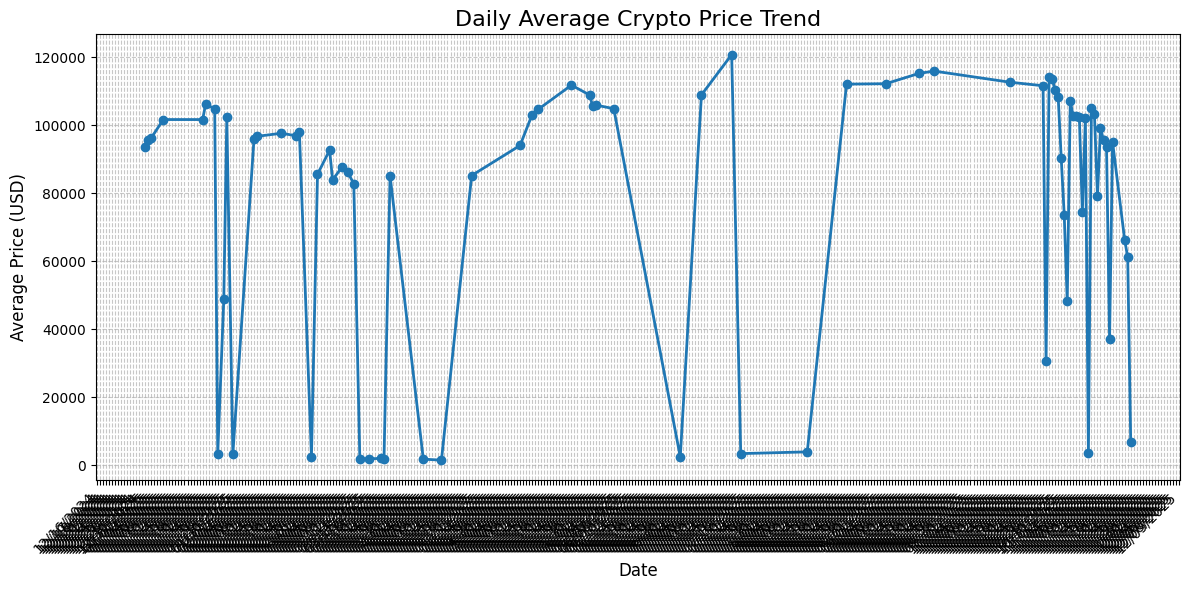

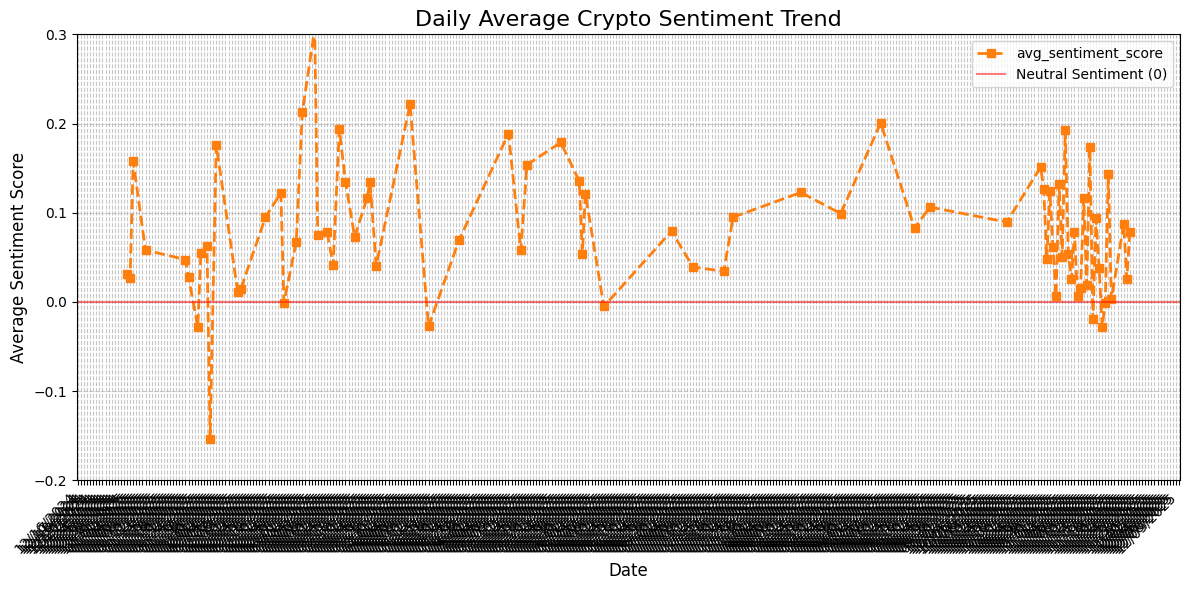

In [63]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

df_daily_mean = (
    df_daily_mean_spark
        .select("avg_sentiment_score", "avg_price", "date")
        .orderBy("date")
        .toPandas()
)
df_daily_mean.head()


# Set 'date' as the index for time-series plotting
df_daily_mean['date'] = pd.to_datetime(df_daily_mean['date'])
df_daily_mean = df_daily_mean.set_index('date')

# ----------------------------------------------------------------------
# 1. Daily Average Price Trend Plot
# ----------------------------------------------------------------------

plt.figure(figsize=(12, 6))

# Plot the price trend
df_daily_mean['avg_price'].plot(
    kind='line',
    marker='o',
    color='tab:blue',
    linewidth=2
)

plt.title("Daily Average Crypto Price Trend", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format X-axis to show dates cleanly
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 2. Daily Average Sentiment Trend Plot
# ----------------------------------------------------------------------

plt.figure(figsize=(12, 6))

# Plot the sentiment trend
df_daily_mean['avg_sentiment_score'].plot(
    kind='line',
    marker='s',
    color='tab:orange',
    linestyle='--',
    linewidth=2
)

plt.axhline(y=0, color='r', linestyle='-', alpha=0.5, label='Neutral Sentiment (0)') # Add neutral line
plt.title("Daily Average Crypto Sentiment Trend", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.ylim(-0.2, 0.3) # Set a fixed Y-limit for better comparison
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Format X-axis to show dates cleanly
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Another way to implement, time series analysis using sentiment_score.

/tmp/ipython-input-2512109514.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_daily_sentiment = df_pandas.set_index('date').resample('M')['sentiment_score_imputed'].mean()


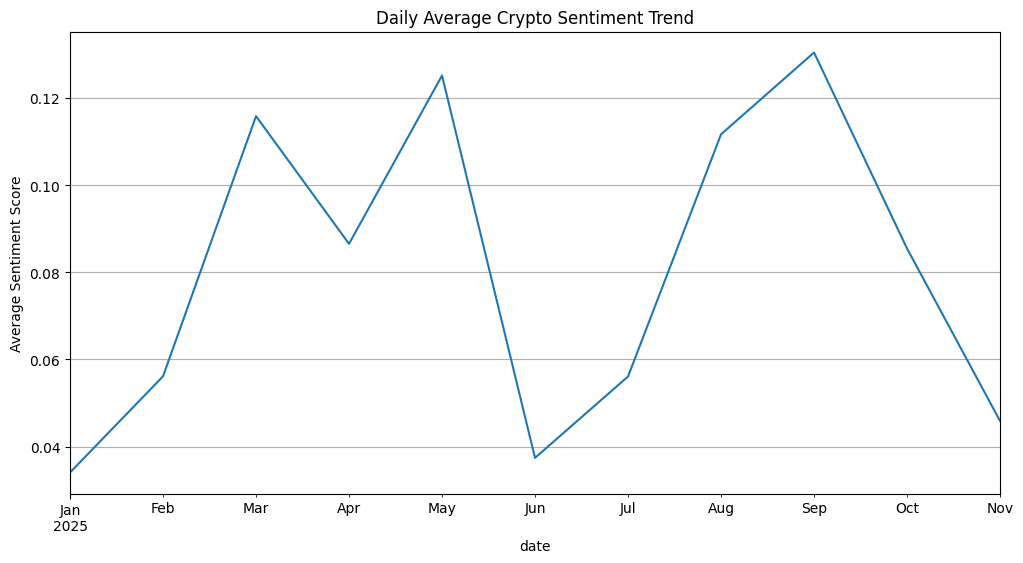

In [64]:
#time series analysis

import matplotlib.pyplot as plt

#convert pyspark dataframe to pandas dataframe
df_pandas = df_reddit_filtered.toPandas()
df_pandas['date'] = pd.to_datetime(df_pandas['date'])
# 1. Overall Sentiment Trend
df_daily_sentiment = df_pandas.set_index('date').resample('M')['sentiment_score_imputed'].mean()

plt.figure(figsize=(12, 6))
df_daily_sentiment.plot(title="Daily Average Crypto Sentiment Trend")
plt.ylabel("Average Sentiment Score")
plt.grid(True)
plt.show()

Let's find out how correlation coefficient affect the pricing data and sentiment score data. It seems like correlation coefficient is postive.

If we've positive correlaltion that means price and sentiment score goes into same direction
If we've negative correelation that means price and sentiment score goes into opposite direction.
Both are type of strong relation.

If we've a 0 correlation that means we've a weak relation between two fields.

In [65]:
df_pandas.head()

,date,cryptocurrency,user_id,type,title,review,sentiment_score,sentiment_score_imputed,sentiment_label,price
0,2025-11-22 04:00:00,BTC,MarioWilson122,comment,Bitcoiners perk up as odds of a December Fed r...,I would like it more if the odds were low head...,0.3134,0.3134,Positive,84518.515625
1,2025-11-22 08:00:00,BTC,CallousBastard,comment,Bitcoin Greed & Fear Index Shows Extreme Pessi...,"I'm old enough to remember 2022. These ""analy...",0.0000,0.0000,Neutral,84135.640625
2,2025-10-31 20:00:00,BTC,Livid_Yam,comment,Trump Isn’t “Pro Crypto”... He’s Pro Trump...a...,He isn't pro USA either\n\nEdit: To keep thing...,-0.5574,-0.5574,Negative,109561.828125
3,2025-11-04 20:00:00,BTC,limlwl,comment,Something appears to be going on at Binance - ...,CEO got pardoned. Now it’s time to pay up.,0.1280,0.1280,Positive,101627.468750
4,2025-11-16 04:00:00,BTC,SlorgSlugmann,comment,Bitcoin just wiped out $120 billion crashing t...,"This is surely the bottom then, right?\n\nrigh...",0.5040,0.5040,Positive,96000.007812


In [74]:
#correlation coefficient with mean
df_reddit_filtered_pd = df_reddit_filtered.toPandas()
# Calculate the Pearson correlation coefficient between the two columns
correlation_coefficient = df_reddit_filtered_pd['price'].corr(df_reddit_filtered_pd['sentiment_score_imputed'])

print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: -0.035622790157718354


I'm performing  same mean for bitcoin

In [67]:
# --- 1. PySpark Aggregation for BTC Only ---
TARGET_CRYPTO = 'BTC' # Targeting Bitcoin
# Filter for BTC, then group by date and aggregate
df_daily_mean_BTC_spark = df_reddit_filtered\
  .filter(F.col("cryptocurrency") == TARGET_CRYPTO)\
    .withColumn(
      'date',
        F.date_trunc('day', F.col('date')) # Truncate 4h interval timestamps to the day
        ).groupBy("date").agg(
            F.mean("sentiment_score_imputed").alias("avg_sentiment_score"),
            F.mean("price").alias("avg_price")
        ).orderBy("date") \
        .withColumn("cryptocurrency", F.lit(TARGET_CRYPTO)) # Add the currency column back

    # Convert the small aggregated result to a local Pandas DataFrame for plotting
df_daily_mean_BTC = df_daily_mean_BTC_spark.toPandas()







In [135]:
print("Total BTC rows:", df_daily_mean_BTC.count())

Total BTC rows: date                   62
avg_sentiment_score    62
avg_price              62
cryptocurrency         62
dtype: int64


In [153]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- Example features and target ---
X = df[['sentiment_score_imputed']].copy()
y = np.where(df['price'].shift(-1) > df['price'], 1, -1)

# Drop the last row after shift
X = X[:-1]
y = y[:-1]

# --- Parameters ---
n_splits = 5
fold_size = len(X) // n_splits

# --- Create folds while preserving class proportions ---
# Get indices of each class
idx_up = np.where(y == 1)[0]
idx_down = np.where(y == -1)[0]

# Split each class into n_splits segments
up_splits = np.array_split(idx_up, n_splits)
down_splits = np.array_split(idx_down, n_splits)

# Combine corresponding segments from both classes to form chronological folds
folds = [np.sort(np.concatenate([up_splits[i], down_splits[i]])) for i in range(n_splits)]

# --- Training & Evaluation ---
accuracies = []
fold_num = 1

for i in range(n_splits):
    # Use all previous folds as training
    train_idx = np.concatenate([folds[j] for j in range(i)]) if i > 0 else np.array([], dtype=int)
    test_idx = folds[i]

    # Skip if no training data
    if len(train_idx) == 0:
        continue

    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]

    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"--- Fold {fold_num} ---")
    print("Training samples:", len(X_train), "Testing samples:", len(X_test))
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    accuracies.append(acc)
    fold_num += 1

print("\nAverage Accuracy across folds:", np.mean(accuracies))


--- Fold 1 ---
Training samples: 2619 Testing samples: 2618
Accuracy: 0.5061115355233002
              precision    recall  f1-score   support

          -1       0.56      0.61      0.59      1484
           1       0.42      0.36      0.39      1134

    accuracy                           0.51      2618
   macro avg       0.49      0.49      0.49      2618
weighted avg       0.50      0.51      0.50      2618

--- Fold 2 ---
Training samples: 5237 Testing samples: 2618
Accuracy: 0.4877769289533995
              precision    recall  f1-score   support

          -1       0.57      0.38      0.46      1484
           1       0.44      0.62      0.51      1134

    accuracy                           0.49      2618
   macro avg       0.50      0.50      0.49      2618
weighted avg       0.51      0.49      0.48      2618

--- Fold 3 ---
Training samples: 7855 Testing samples: 2617
Accuracy: 0.4738249904470768
              precision    recall  f1-score   support

          -1       0.56 

We got 0.50 accuracy for bitcoin in random forrest. Now let's do LSTM and SVM and we'll compare accuracy score

In [75]:
    pip install tensorflow

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Models Trained Successfully

CLASSIFICATION METRICS: DIRECTIONAL ACCURACY

--- LSTM Classification Report (Directional Accuracy) ---
Accuracy:  0.5833
Precision: 0.4444
Recall:    1.0000

Detailed Report:
               precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.44      1.00      0.62         4

    accuracy                           0.58        12
   macro avg       0.72      0.69      0.58        12
weighted avg       0.81      0.58      0.57        12


--- SVM Classification Report (Directional Accuracy) ---
Accuracy:  0.7500
Precision: 0.6000
Recall:    0.7500

Detailed Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



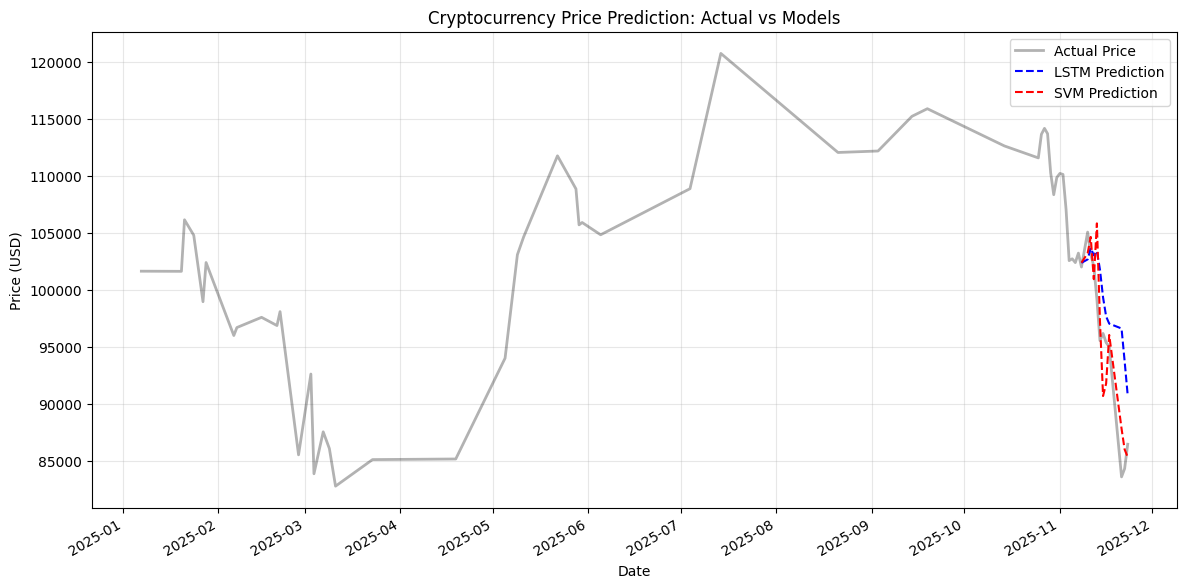

In [131]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



# Convert Spark DataFrame to Pandas DataFrame
# This brings data to the driver node
pdf = df_daily_mean_BTC_spark.select("avg_price", "avg_sentiment_score").toPandas()

# --- From here, the code is identical to your original workflow ---
data = pdf.values
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
#scaler = RobustScaler()
scaled_data = scaler.fit_transform(data)

# Create Sequences
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3
X, y = create_dataset(scaled_data, look_back)

# Split Train/Test
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(look_back, 2)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.fit(X_train, y_train, epochs=100, verbose=0)

#Generate predictions
# --- 1. Generate Predictions ---
# LSTM Prediction
train_predict_lstm = model_lstm.predict(X_train, verbose=0)
test_predict_lstm = model_lstm.predict(X_test, verbose=0)



# SVM
X_train_svm = X_train.reshape(X_train.shape[0], -1)
X_test_svm = X_test.reshape(X_test.shape[0], -1)
model_svm = SVR(kernel='rbf')
model_svm.fit(X_train_svm, y_train)
test_predict_svm = model_svm.predict(X_test_svm)
train_predict_svm = model_svm.predict(X_train_svm)
print("Models Trained Successfully")


# --- 2. Inverse Transform (Un-scale) ---
# The scaler expects 2 features (Price, Sentiment), but our predictions are just Price (1 feature).
# We create a helper function to pad the prediction with a dummy column to satisfy the scaler.

def inverse_transform_price(pred_array, scaler):
    # Create a dummy array with the same shape as the original input (samples, 2)
    dummy = np.zeros((len(pred_array), 2))
    # Place predictions in the first column (Price)
    dummy[:, 0] = pred_array.flatten()
    # Inverse transform and return only the price column
    return scaler.inverse_transform(dummy)[:, 0]

# Apply the function
y_train_real = inverse_transform_price(y_train, scaler)
y_test_real = inverse_transform_price(y_test, scaler)

lstm_train_real = inverse_transform_price(train_predict_lstm, scaler)
lstm_test_real = inverse_transform_price(test_predict_lstm, scaler)

svm_train_real = inverse_transform_price(train_predict_svm, scaler)
svm_test_real = inverse_transform_price(test_predict_svm, scaler)

# ==============================================================================
# --- 3. CLASSIFICATION METRICS (DIRECTIONAL ACCURACY) ---
# ==============================================================================
print("\n" + "="*50)
print("CLASSIFICATION METRICS: DIRECTIONAL ACCURACY")
print("="*50)

# 1. Get the price just before the target (Previous Price)
# X_test[:, -1, 0] gets the price feature (index 0) from the last time step (index -1)
prev_prices_scaled = X_test[:, -1, 0]
prev_prices_real = inverse_transform_price(prev_prices_scaled, scaler)

# 2. Construct Binary Classes (1 = Price UP, 0 = Price DOWN/Same)
# Actual Movement: Did the price go up relative to the previous day?
actual_direction = (y_test_real > prev_prices_real).astype(int)

# Predicted Movement (LSTM): Did the prediction suggest the price went up?
lstm_direction = (lstm_test_real > prev_prices_real).astype(int)

# Predicted Movement (SVM): Did the prediction suggest the price went up?
svm_direction = (svm_test_real > prev_prices_real).astype(int)

# 3. Calculate and Print Metrics for LSTM
print("\n--- LSTM Classification Report (Directional Accuracy) ---")
print(f"Accuracy:  {accuracy_score(actual_direction, lstm_direction):.4f}")
print(f"Precision: {precision_score(actual_direction, lstm_direction, zero_division=0):.4f}")
print(f"Recall:    {recall_score(actual_direction, lstm_direction, zero_division=0):.4f}")
print("\nDetailed Report:\n", classification_report(actual_direction, lstm_direction, zero_division=0))

# 4. Calculate and Print Metrics for SVM
print("\n--- SVM Classification Report (Directional Accuracy) ---")
print(f"Accuracy:  {accuracy_score(actual_direction, svm_direction):.4f}")
print(f"Precision: {precision_score(actual_direction, svm_direction, zero_division=0):.4f}")
print(f"Recall:    {recall_score(actual_direction, svm_direction, zero_division=0):.4f}")
print("\nDetailed Report:\n", classification_report(actual_direction, svm_direction, zero_division=0))

# Update this line in your existing code to include 'date'
pdf = df_daily_mean_BTC_spark.select("date", "avg_price", "avg_sentiment_score").toPandas()

##--- 3. Align Dates ---
# We need to match the data points to their original timestamps
# The first 'look_back' rows were consumed to create the first sequence
timestamps = pdf['date'].values[look_back:]

# Split timestamps into train and test to match the X splits
train_dates = timestamps[:train_size]
test_dates = timestamps[train_size:]

# --- 4. Plotting ---
plt.figure(figsize=(14, 7))

# Plot Actual Prices (Ground Truth)
# We concatenate train and test to show the full continuous line
plt.plot(timestamps, np.concatenate([y_train_real, y_test_real]),
         label='Actual Price', color='black', linewidth=2, alpha=0.3)

# Plot LSTM Predictions (Test Set)
plt.plot(test_dates, lstm_test_real,
         label='LSTM Prediction', color='blue', linestyle='--', linewidth=1.5)

# Plot SVM Predictions (Test Set)
plt.plot(test_dates, svm_test_real,
         label='SVM Prediction', color='red', linestyle='--', linewidth=1.5)

plt.title('Cryptocurrency Price Prediction: Actual vs Models')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# Format date axis for better readability
plt.gcf().autofmt_xdate()

plt.show()

LSTM is around giving 58% accuracy and SVM is providing around 75% accuracy

forecasting for next 30 days

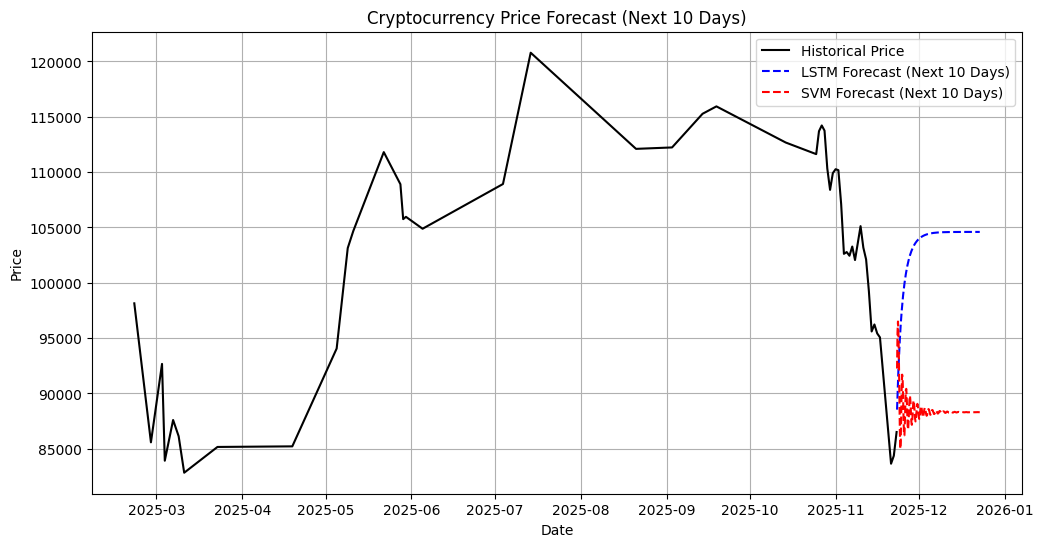

In [132]:
#forecasting for next ten days
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# --- 1. Setup Forecast Parameters ---
# 30 days * 6 intervals per day (since data is 4-hourly) = 30 steps
future_steps = 180

# Get the last sequence from your original data to start the chain
# Shape: (1, look_back, 2)
last_sequence = scaled_data[-look_back:]
current_batch = last_sequence.reshape(1, look_back, 2)

# We need to store predictions
lstm_forecast = []
svm_forecast = []

# For the simulation, we must assume future sentiment.
# We will use the last known sentiment value to remain conservative.
last_sentiment = last_sequence[-1, 1]

# --- 2. Generate LSTM Forecast ---
curr_lstm = current_batch.copy()
for i in range(future_steps):
    # Predict next price (output is scaled)
    pred_price = model_lstm.predict(curr_lstm, verbose=0)[0, 0]
    lstm_forecast.append(pred_price)

    # Create new input row: [Predicted_Price, Last_Sentiment]
    new_row = np.array([[pred_price, last_sentiment]])

    # Update batch: Drop oldest time step, add new prediction
    curr_lstm = np.append(curr_lstm[:, 1:, :], [new_row], axis=1)

# --- 3. Generate SVM Forecast ---
# SVM needs 2D input (1, look_back * 2)
curr_svm = current_batch.copy()
for i in range(future_steps):
    # Flatten for SVM
    svm_input = curr_svm.reshape(1, -1)

    pred_price = model_svm.predict(svm_input)[0]
    svm_forecast.append(pred_price)

    new_row = np.array([[pred_price, last_sentiment]])

    # Update batch for next iteration (maintain 3D shape for easy manipulation)
    curr_svm = np.append(curr_svm[:, 1:, :], [new_row], axis=1)

# --- 4. Inverse Scale Predictions ---
# Scaler expects 2 columns (Price, Sentiment), so we pad with zeros to inverse transform
def inverse_scale_forecast(forecast_list, scaler):
    dummy_array = np.zeros((len(forecast_list), 2))
    dummy_array[:, 0] = forecast_list # Fill price column
    return scaler.inverse_transform(dummy_array)[:, 0]

lstm_forecast_real = inverse_scale_forecast(lstm_forecast, scaler)
svm_forecast_real = inverse_scale_forecast(svm_forecast, scaler)

# --- 5. Create Future Dates ---
last_date = pd.to_datetime(pdf['date'].max()) # Assuming 'timestamp' is in your pdf
future_dates = [last_date + timedelta(hours=4 * (i+1)) for i in range(future_steps)]

# --- 6. Plotting ---
plt.figure(figsize=(12, 6))

# Plot last 50 actual data points for context
plt.plot(pdf['date'].tail(50), pdf['avg_price'].tail(50), label='Historical Price', color='black')

# Plot Forecasts
plt.plot(future_dates, lstm_forecast_real, label='LSTM Forecast (Next 10 Days)', color='blue', linestyle='--')
plt.plot(future_dates, svm_forecast_real, label='SVM Forecast (Next 10 Days)', color='red', linestyle='--')

plt.title('Cryptocurrency Price Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Previously, I was using reddit_filtered dataframe which was causing memory issues because of too much data so I'm using filtered approach first

In [120]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load and prepare data
# -----------------------------
pdf = df_reddit_filtered.filter("cryptocurrency = 'BTC'").toPandas()
pdf['date'] = pd.to_datetime(pdf['date'])
pdf = pdf.sort_values('date')

# Define sentiment classes
def sentiment_label(score):
    if score > 0.1: return 2
    elif score < -0.1: return 0
    else: return 1

pdf['sentiment_class'] = pdf['sentiment_score_imputed'].apply(sentiment_label)

# Split train/test
train_mask = (pdf['date'] >= '2025-01-01') & (pdf['date'] <= '2025-10-27')
test_mask  = (pdf['date'] >= '2025-10-28') & (pdf['date'] <= '2025-11-27')

pdf_train = pdf[train_mask]
pdf_test  = pdf[test_mask]

# Features for LSTM/SVM
features = ['price', 'sentiment_score_imputed']

# Scale features for price regression
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(pdf_train[features])
scaled_test  = scaler.transform(pdf_test[features])

# -----------------------------
# 2. Create sequences
# -----------------------------
look_back = 3

def create_sequences(X, y, look_back=3):
    X_seq, y_seq = [], []
    for i in range(len(X) - look_back):
        X_seq.append(X[i:i+look_back])
        y_seq.append(y[i+look_back])
    return np.array(X_seq), np.array(y_seq)

# For price forecasting
X_train_price, y_train_price = create_sequences(scaled_train, pdf_train['price'].values, look_back)
X_test_price,  y_test_price  = create_sequences(scaled_test,  pdf_test['price'].values, look_back)

# For sentiment classification
X_train_sent, y_train_sent = create_sequences(scaled_train, pdf_train['sentiment_class'].values, look_back)
X_test_sent,  y_test_sent  = create_sequences(scaled_test,  pdf_test['sentiment_class'].values, look_back)

# -----------------------------
# 3. Class weights for sentiment
# -----------------------------
classes = np.unique(y_train_sent)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_sent)
class_weight_dict = dict(zip(classes, weights))

# One-hot encode sentiment for LSTM
y_train_cat = to_categorical(y_train_sent, num_classes=3)
y_test_cat  = to_categorical(y_test_sent, num_classes=3)

# -----------------------------
# 4. LSTM for sentiment classification
# -----------------------------
model_lstm_sent = Sequential()
model_lstm_sent.add(LSTM(50, input_shape=(look_back, 2)))
model_lstm_sent.add(Dense(3, activation='softmax'))
model_lstm_sent.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm_sent.fit(X_train_sent, y_train_cat, epochs=50, batch_size=32, verbose=1, class_weight=class_weight_dict)

y_pred_prob = model_lstm_sent.predict(X_test_sent)
y_pred_class = np.argmax(y_pred_prob, axis=1)

print("LSTM Sentiment Accuracy:", accuracy_score(y_test_sent, y_pred_class))
print(classification_report(y_test_sent, y_pred_class, target_names=['Negative','Neutral','Positive']))

# -----------------------------
# 5. SVM for sentiment classification
# -----------------------------
X_train_svm = X_train_sent.reshape(X_train_sent.shape[0], -1)
X_test_svm  = X_test_sent.reshape(X_test_sent.shape[0], -1)

model_svm_sent = SVC(kernel='rbf', class_weight='balanced')
model_svm_sent.fit(X_train_svm, y_train_sent)

y_svm_pred = model_svm_sent.predict(X_test_svm)
print("SVM Sentiment Accuracy:", accuracy_score(y_test_sent, y_svm_pred))
print(classification_report(y_test_sent, y_svm_pred, target_names=['Negative','Neutral','Positive']))



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3125 - loss: 1.1061
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3755 - loss: 1.0989
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3251 - loss: 1.1033
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3777 - loss: 1.0953
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3508 - loss: 1.1028
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3750 - loss: 1.0970
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3571 - loss: 1.1013
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3976 - loss: 1.0917
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3254 - loss: 1.1022
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3807 - loss: 1.0952
Epoch 11/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3584 - loss: 1.0984
Epoch 12/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [121]:
# -----------------------------
# 6. LSTM for price forecasting
# -----------------------------
model_lstm_price = Sequential()
model_lstm_price.add(LSTM(50, input_shape=(look_back, 2)))
model_lstm_price.add(Dense(1))
model_lstm_price.compile(loss='mse', optimizer='adam')

model_lstm_price.fit(X_train_price, y_train_price, epochs=50, batch_size=32, verbose=1)

# Predictions
train_predict_lstm = model_lstm_price.predict(X_train_price)
test_predict_lstm  = model_lstm_price.predict(X_test_price)

# -----------------------------
# 7. SVR for price forecasting
# -----------------------------
X_train_svr = X_train_price.reshape(X_train_price.shape[0], -1)
X_test_svr  = X_test_price.reshape(X_test_price.shape[0], -1)

model_svr = SVR(kernel='rbf')
model_svr.fit(X_train_svr, y_train_price)

train_predict_svr = model_svr.predict(X_train_svr)
test_predict_svr  = model_svr.predict(X_test_svr)

# -----------------------------
# 8. Inverse scale price predictions
# -----------------------------
def inverse_transform_price(pred_array, scaler):
    dummy = np.zeros((len(pred_array), 2))
    dummy[:, 0] = pred_array.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

y_train_real = pdf_train['price'].values[look_back:]
y_test_real  = pdf_test['price'].values[look_back:]

lstm_train_real = inverse_transform_price(train_predict_lstm, scaler)
lstm_test_real  = inverse_transform_price(test_predict_lstm, scaler)

svr_train_real = inverse_transform_price(train_predict_svr, scaler)
svr_test_real  = inverse_transform_price(test_predict_svr, scaler)

timestamps_train = pdf_train['date'].values[look_back:]
timestamps_test  = pdf_test['date'].values[look_back:]





/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 10202549248.0000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10240560128.0000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10222916608.0000
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10200059904.0000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10186766336.0000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10203537408.0000
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10214499328.0000
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10184849408.0000
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10160559104.0000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10171353088.0000
Epoch 11/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10159960064.0000
Epoch 12/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10159188992.0000
Epoch 13/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10182965248.

In [91]:
df_daily_mean_BTC = df_daily_mean_BTC_spark.toPandas()

df_daily_mean_BTC.columns

Index(['date', 'avg_sentiment_score', 'avg_price', 'cryptocurrency'], dtype='object')

I'm performing timeseries analysis for bitcoin

set date index


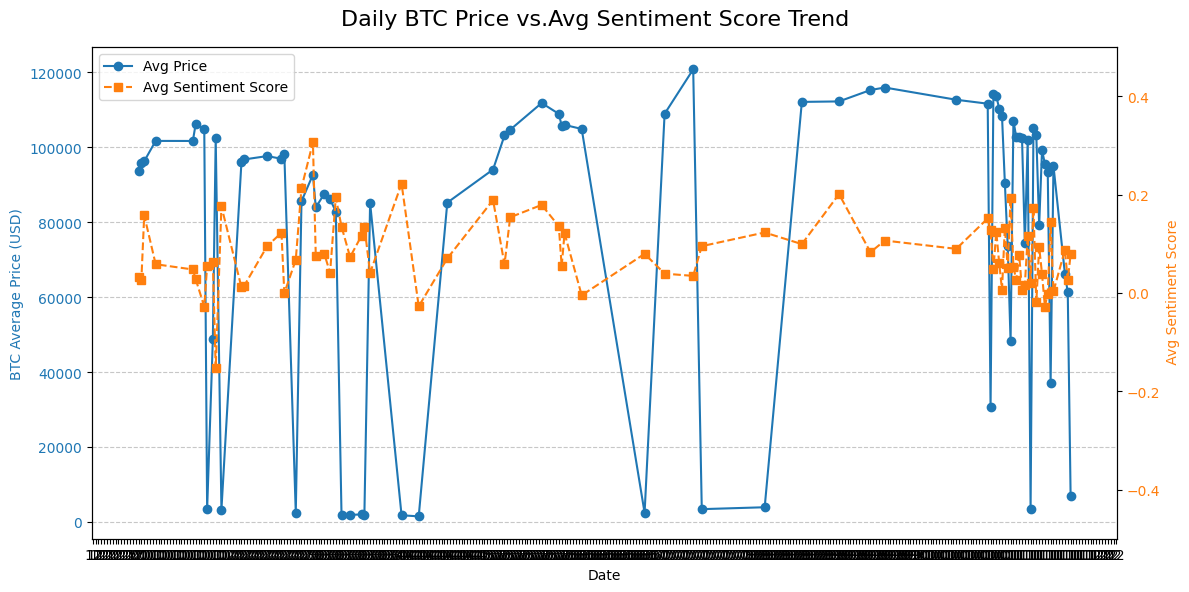

In [92]:
# --- 2. Pandas Plotting (Dual-Axis) ---

df_daily_mean_BTC = df_daily_mean_spark.select("avg_price", "avg_sentiment_score", "date")\
    .orderBy("date")\
    .toPandas()

if not df_daily_mean_BTC.empty:
    df_daily_mean_BTC['date'] = pd.to_datetime(df_daily_mean_BTC['date'])

    df_daily_mean_BTC = df_daily_mean_BTC.set_index('date')

    print("set date index")

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot 1: Average Price (Primary Y-axis, left)
    color_price = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{TARGET_CRYPTO} Average Price (USD)', color=color_price)
    line1 = ax1.plot(df_daily_mean_BTC.index, df_daily_mean_BTC['avg_price'], color=color_price, marker='o', linestyle='-', label='Avg Price')
    ax1.tick_params(axis='y', labelcolor=color_price)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Average Sentiment Score (Secondary Y-axis, right)
    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    color_sentiment = 'tab:orange'
    ax2.set_ylabel(' Avg Sentiment Score', color=color_sentiment)
    line2 = ax2.plot(df_daily_mean_BTC.index, df_daily_mean_BTC['avg_sentiment_score'], color=color_sentiment, marker='s', linestyle='--', label='Avg Sentiment Score')
    ax2.tick_params(axis='y', labelcolor=color_sentiment)
    ax2.set_ylim(-0.5, 0.5) # Set a fixed y-limit for sentiment score for readability

    # Add a combined title and legend
    fig.suptitle(f'Daily {TARGET_CRYPTO} Price vs.Avg Sentiment Score Trend', fontsize=16)

    # Combine legends from both axes
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    # Format X-axis for better date display
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    plt.xticks(rotation=45, ha='right')

    fig.tight_layout()
    plt.show()
else:
    print(f"❌ Cannot plot: DataFrame for {TARGET_CRYPTO} is empty after aggregation.")

In [136]:
df_daily_mean_BTC.head()

,date,avg_sentiment_score,avg_price,cryptocurrency
0,2025-01-01,0.031352,93614.742188,BTC
1,2025-01-02,0.026933,95696.812500,BTC
2,2025-01-03,0.157703,96270.570312,BTC
3,2025-01-07,0.058204,101686.375000,BTC
4,2025-01-20,0.047550,101674.656250,BTC


In [137]:
#correlation coefficient with mean for BTC

# Calculate the Pearson correlation coefficient between the two columns
correlation_coefficient = df_daily_mean_BTC['avg_price'].corr(df_daily_mean_BTC['avg_sentiment_score'])

print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.044218186532700175


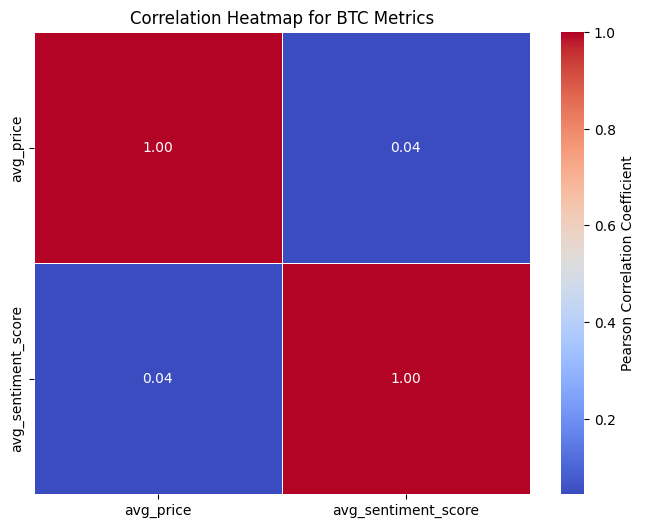

In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select the relevant numerical columns from your DataFrame
# Include 'avg_price', 'avg_sentiment_score', and any other numerical columns

numerical_features = [
    'avg_price',
    'avg_sentiment_score',

]

# Create the correlation matrix
correlation_matrix = df_daily_mean_BTC[numerical_features].corr(method='pearson')

# 2. Plot the Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Show the correlation values on the map
    cmap='coolwarm',     # Use a clear color scheme
    fmt=".2f",           # Format the numbers to two decimal places
    linewidths=.5,       # Add lines between cells for clarity
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)

plt.title('Correlation Heatmap for BTC Metrics')
plt.show()

In [139]:
df_daily_mean_BTC.head(n=3)

,date,avg_sentiment_score,avg_price,cryptocurrency
0,2025-01-01,0.031352,93614.742188,BTC
1,2025-01-02,0.026933,95696.812500,BTC
2,2025-01-03,0.157703,96270.570312,BTC


In [140]:
#Daily Price Difference for BTC

if 'date' in df_daily_mean_BTC.columns:
      df_daily_mean_BTC['date'] = pd.to_datetime(df_daily_mean_BTC['date'])
      df_daily_mean_BTC = df_daily_mean_BTC.set_index('date').sort_index()
else:
        # If 'date' is already the index, ensure the index type is correct
      if not pd.api.types.is_datetime64_any_dtype(df_daily_mean_BTC.index):
          df_daily_mean_BTC.index = pd.to_datetime(df_daily_mean_BTC.index)
          df_daily_mean_BTC = df_daily_mean_BTC.sort_index()

# --- NEW CALCULATION: Daily Price Difference ---
    # 1. Calculate the price difference by subtracting the previous day's price.
df_daily_mean_BTC['daily_price_difference'] = (
        df_daily_mean_BTC['avg_price'] - df_daily_mean_BTC['avg_price'].shift(1)
    )

df_daily_mean_reset = df_daily_mean_BTC.reset_index()
print("\n--- DataFrame after Resetting Index (All columns are selectable) ---")
# FIX: Print the head directly to show 'date' as a column, avoiding the KeyError
print(df_daily_mean_reset.head().to_markdown(numalign="left", stralign="left", floatfmt=",.2f"))

   # The first day's difference will be NaN, which is correct.
print(f"\n--- Daily Price Difference for BTC ---")
print(df_daily_mean_BTC.head(n=30))








--- DataFrame after Resetting Index (All columns are selectable) ---
|    | date                | avg_sentiment_score   | avg_price   | cryptocurrency   | daily_price_difference   |
|:---|:--------------------|:----------------------|:------------|:-----------------|:-------------------------|
| 0  | 2025-01-01 00:00:00 | 0.03                  | 93,614.74   | BTC              | nan                      |
| 1  | 2025-01-02 00:00:00 | 0.03                  | 95,696.81   | BTC              | 2,082.07                 |
| 2  | 2025-01-03 00:00:00 | 0.16                  | 96,270.57   | BTC              | 573.76                   |
| 3  | 2025-01-07 00:00:00 | 0.06                  | 101,686.38  | BTC              | 5,415.80                 |
| 4  | 2025-01-20 00:00:00 | 0.05                  | 101,674.66  | BTC              | -11.72                   |

--- Daily Price Difference for BTC ---
            avg_sentiment_score      avg_price cryptocurrency  \
date                              

In [141]:
# --- 1. PySpark Aggregation for BTC Only ---
TARGET_CRYPTO = 'ETH' # Targeting Bitcoin
# Filter for BTC, then group by date and aggregate
df_daily_mean_ETH_spark = df_reddit_filtered\
  .filter(F.col("cryptocurrency") == TARGET_CRYPTO)\
    .withColumn(
      'date',
        F.date_trunc('day', F.col('date')) # Truncate 4h interval timestamps to the day
        ).groupBy("date").agg(
            F.mean("sentiment_score").alias("avg_sentiment_score"),
            F.mean("price").alias("avg_price")
        ).orderBy("date") \
        .withColumn("cryptocurrency", F.lit(TARGET_CRYPTO)) # Add the currency column back

    # Convert the small aggregated result to a local Pandas DataFrame for plotting
df_daily_mean_ETH = df_daily_mean_ETH_spark.toPandas()


In [142]:
df_daily_mean_ETH.head()

,date,avg_sentiment_score,avg_price,cryptocurrency
0,2025-01-25,0.055107,3336.774170,ETH
1,2025-01-27,0.126351,3182.691162,ETH
2,2025-01-30,0.175939,3248.369873,ETH
3,2025-02-25,0.067131,2499.940186,ETH
4,2025-03-13,0.134799,1873.580200,ETH


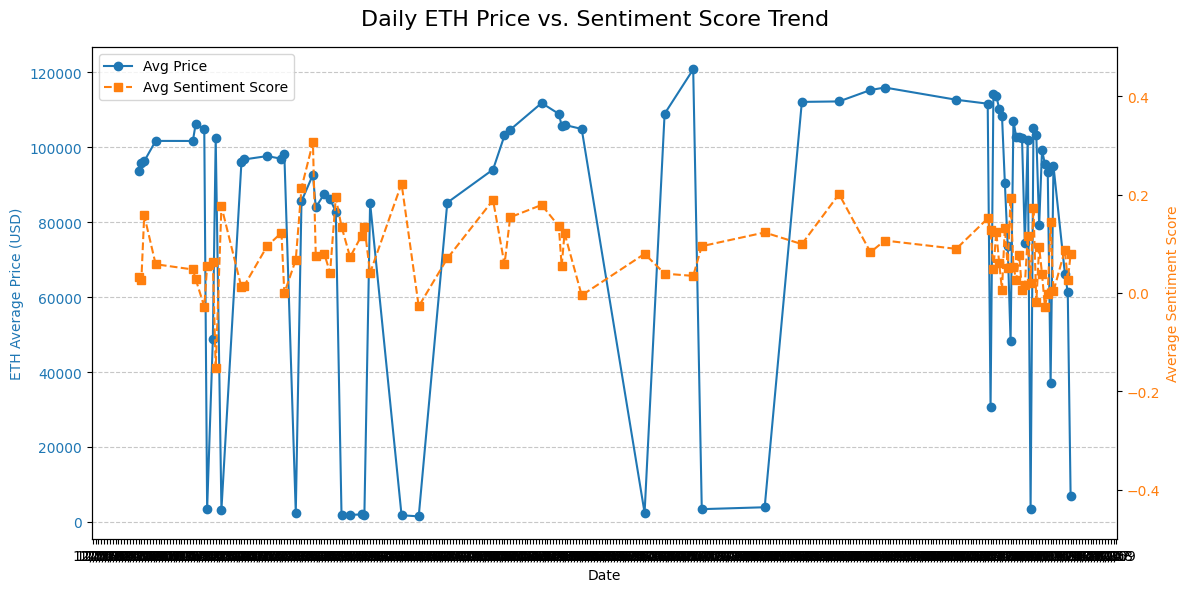

In [145]:
# --- 2. Pandas Plotting (Dual-Axis) ---
if not df_daily_mean_ETH.empty:
    df_daily_mean_ETH = df_daily_mean_spark.select("avg_price", "avg_sentiment_score", "date")\
    .orderBy("date")\
    .toPandas()
    df_daily_mean_ETH = df_daily_mean_ETH.set_index('date')

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot 1: Average Price (Primary Y-axis, left)
    color_price = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'ETH Average Price (USD)', color=color_price)
    line1 = ax1.plot(df_daily_mean_ETH.index, df_daily_mean_ETH['avg_price'], color=color_price, marker='o', linestyle='-', label='Avg Price')
    ax1.tick_params(axis='y', labelcolor=color_price)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Average Sentiment Score (Secondary Y-axis, right)
    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    color_sentiment = 'tab:orange'
    ax2.set_ylabel('Average Sentiment Score', color=color_sentiment)
    line2 = ax2.plot(df_daily_mean_ETH.index, df_daily_mean_ETH['avg_sentiment_score'], color=color_sentiment, marker='s', linestyle='--', label='Avg Sentiment Score')
    ax2.tick_params(axis='y', labelcolor=color_sentiment)
    ax2.set_ylim(-0.5, 0.5) # Set a fixed y-limit for sentiment score for readability

    # Add a combined title and legend
    fig.suptitle(f'Daily ETH Price vs. Sentiment Score Trend', fontsize=16)

    # Combine legends from both axes
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    # Format X-axis for better date display
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.xticks(rotation=45, ha='right')

    fig.tight_layout()
    plt.show()
else:
    print(f"❌ Cannot plot: DataFrame for {TARGET_CRYPTO} is empty after aggregation.")

In [146]:
#Daily Price Difference for ETH

if 'date' in df_daily_mean_ETH.columns:
      df_daily_mean_ETH['date'] = pd.to_datetime(df_daily_mean_ETH['date'])
      df_daily_mean_ETH = df_daily_mean_ETH.set_index('date').sort_index()
else:
        # If 'date' is already the index, ensure the index type is correct
      if not pd.api.types.is_datetime64_any_dtype(df_daily_mean_ETH.index):
          df_daily_mean_ETH.index = pd.to_datetime(df_daily_mean_ETH.index)
          df_daily_mean_ETH = df_daily_mean_ETH.sort_index()

# --- NEW CALCULATION: Daily Price Difference ---
    # 1. Calculate the price difference by subtracting the previous day's price.
df_daily_mean_ETH['daily_price_difference'] = (
        df_daily_mean_ETH['avg_price'] - df_daily_mean_ETH['avg_price'].shift(1)
    )

df_daily_mean_reset = df_daily_mean_ETH.reset_index()
print("\n--- DataFrame after Resetting Index (All columns are selectable) ---")
# FIX: Print the head directly to show 'date' as a column, avoiding the KeyError
print(df_daily_mean_reset.head().to_markdown(numalign="left", stralign="left", floatfmt=",.2f"))

   # The first day's difference will be NaN, which is correct.
print(f"\n--- Daily Price Difference for ETH ---")
print(df_daily_mean_ETH.head(n=30))








--- DataFrame after Resetting Index (All columns are selectable) ---
|    | date                | avg_price   | avg_sentiment_score   | daily_price_difference   |
|:---|:--------------------|:------------|:----------------------|:-------------------------|
| 0  | 2025-01-01 00:00:00 | 93,614.74   | 0.03                  | nan                      |
| 1  | 2025-01-02 00:00:00 | 95,696.81   | 0.03                  | 2,082.07                 |
| 2  | 2025-01-03 00:00:00 | 96,270.57   | 0.16                  | 573.76                   |
| 3  | 2025-01-07 00:00:00 | 101,686.38  | 0.06                  | 5,415.80                 |
| 4  | 2025-01-20 00:00:00 | 101,674.66  | 0.05                  | -11.72                   |

--- Daily Price Difference for ETH ---
                avg_price  avg_sentiment_score  daily_price_difference
date                                                                  
2025-01-01   93614.742188             0.031352                     NaN
2025-01-02   95696.

In [ ]:
#correlation coefficient with mean for ETH

# Calculate the Pearson correlation coefficient between the two columns
correlation_coefficient_ETH = df_daily_mean_ETH['avg_price'].corr(df_daily_mean_ETH['avg_sentiment_score'])

print(f"Correlation Coefficient: {correlation_coefficient_ETH}")

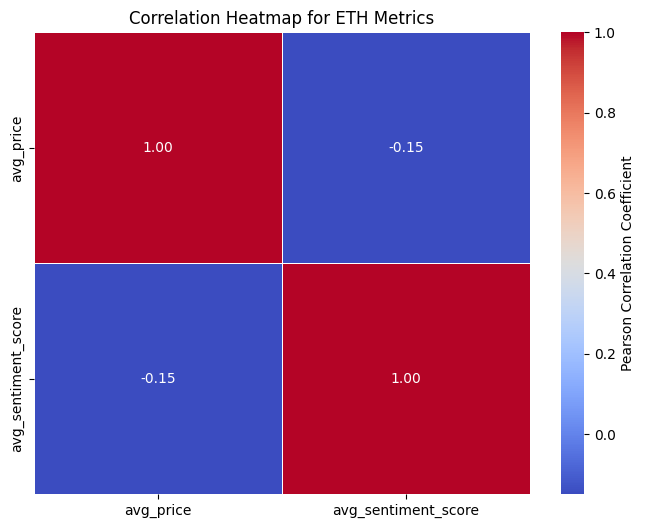

In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select the relevant numerical columns from your DataFrame
# Include 'avg_price', 'avg_sentiment_score', and any other numerical columns

numerical_features = [
    'avg_price',
    'avg_sentiment_score',

]

# Create the correlation matrix
correlation_matrix = df_daily_mean_ETH[numerical_features].corr(method='pearson')

# 2. Plot the Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Show the correlation values on the map
    cmap='coolwarm',     # Use a clear color scheme
    fmt=".2f",           # Format the numbers to two decimal places
    linewidths=.5,       # Add lines between cells for clarity
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)

plt.title('Correlation Heatmap for ETH Metrics')
plt.show()

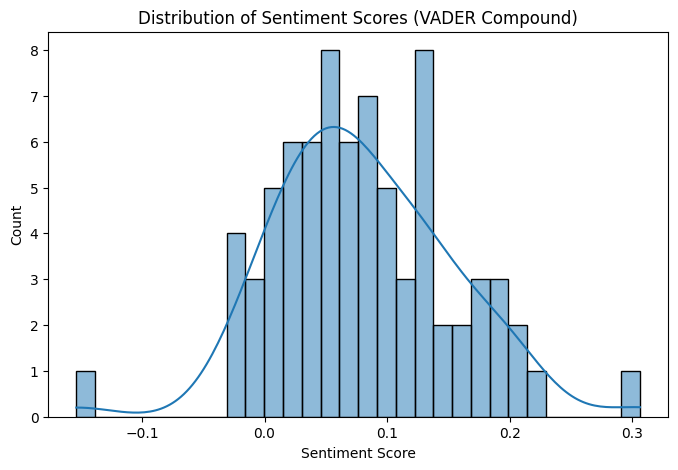

In [148]:
#distribution analysis: Visualize the distribution
#of the core metric, sentiment_score, to see if the overall mood is neutral, positive, or negative.

import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_daily_mean['avg_sentiment_score'], bins=30, kde=True)
plt.title("Distribution of Sentiment Scores (VADER Compound)")
plt.xlabel("Sentiment Score")
plt.show()

/tmp/ipython-input-3127082703.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'cryptocurrency', y='unique_user_count',data=df_pandas_count, palette='viridis')


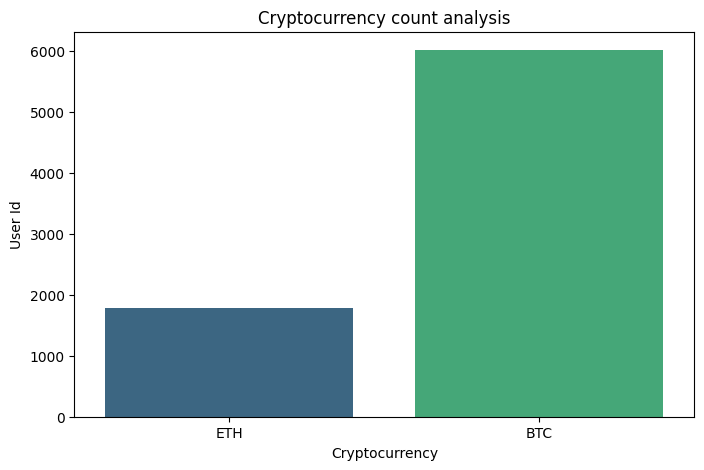

In [149]:

import seaborn as sns

from pyspark.sql import functions as F

# 1. Group by cryptocurrency and count the number of records (posts/comments).
#df_count_spark = df_filtered_and_joined.groupBy("cryptocurrency").count().orderBy(F.desc("count"))

from pyspark.sql.functions import col, countDistinct
df_count_spark =  df_reddit_filtered.groupBy("cryptocurrency").agg(countDistinct("user_id").alias("unique_user_count"))

# 2. Convert the small aggregated result to a Pandas DataFrame for plotting.
df_pandas_count = df_count_spark.toPandas()
plt.figure(figsize=(8, 5))
sns.barplot(x= 'cryptocurrency', y='unique_user_count',data=df_pandas_count, palette='viridis')
plt.title("Cryptocurrency count analysis")
plt.xlabel("Cryptocurrency")
plt.ylabel("User Id")
plt.show()

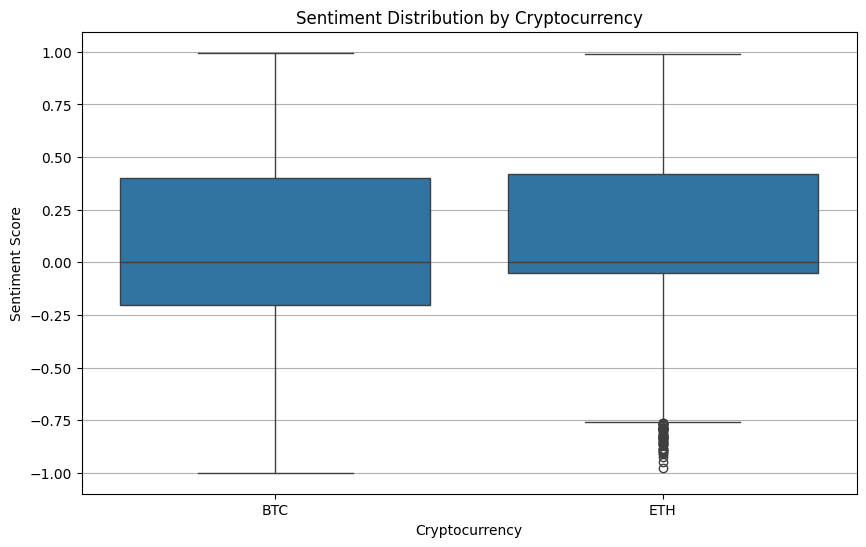


--- Mean Sentiment by Coin ---
cryptocurrency
ETH    0.096629
BTC    0.056104
Name: sentiment_score_imputed, dtype: float64


In [150]:
#Distribution analysis

plt.figure(figsize=(10, 6))
# Create a box plot to compare the sentiment distribution across different cryptocurrencies
sns.boxplot(x='cryptocurrency', y='sentiment_score_imputed', data=df_pandas)
plt.title("Sentiment Distribution by Cryptocurrency")
plt.xlabel("Cryptocurrency")
plt.ylabel("Sentiment Score")
plt.grid(axis='y')
plt.show()

# Calculate the mean sentiment for each coin
mean_sentiment_by_coin = df_pandas.groupby('cryptocurrency')['sentiment_score_imputed'].mean().sort_values(ascending=False)
print("\n--- Mean Sentiment by Coin ---")
print(mean_sentiment_by_coin)

In [ ]:
df_pandas.columns

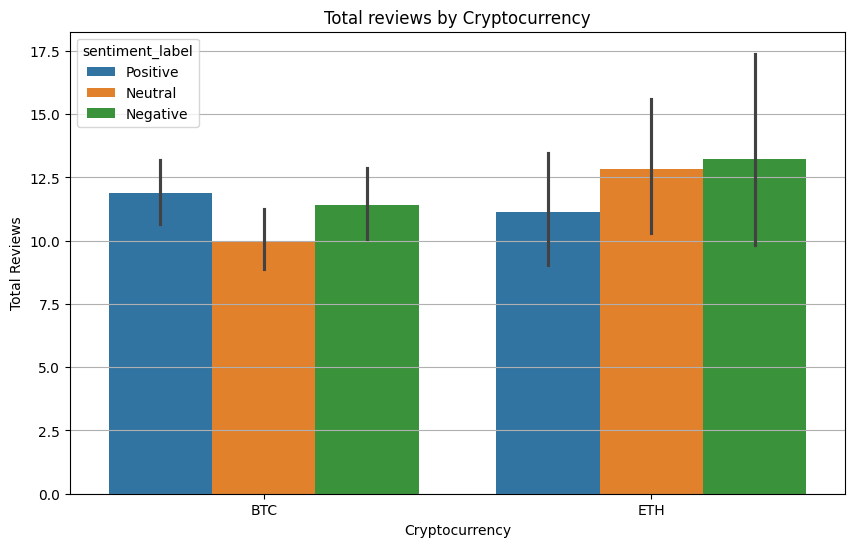


--- Mean Sentiment by Coin ---
cryptocurrency
BTC    100170.466600
ETH      2920.668685
Name: price, dtype: float64


In [151]:
#Distribution analysis

import seaborn as sns
df_pandas['total_reviews_per_userid'] = df_pandas.groupby('user_id')['user_id'].transform('count')

plt.figure(figsize=(10, 6))
# Create a box plot to compare the sentiment distribution across different cryptocurrencies
sns.barplot(x='cryptocurrency', y='total_reviews_per_userid', data=df_pandas,hue='sentiment_label',)
plt.title("Total reviews by Cryptocurrency")
plt.xlabel("Cryptocurrency")
plt.ylabel("Total Reviews")
plt.grid(axis='y')
plt.show()

# Calculate the mean sentiment for each coin
mean_price_by_coin = df_pandas.groupby('cryptocurrency')['price'].mean().sort_values(ascending=False)
print("\n--- Mean Sentiment by Coin ---")
print(mean_price_by_coin)

In [ ]:
#remove rows which has a garbage timestamp or null timestamp --done

In [ ]:
#create a bar chart for cryptocurrency to demonstrate number of users who post and comment for cryptocurrency -- done

In [ ]:
#create a column chart for number of title and revviews for cryptocurrency

In [ ]:
#create a bar chart to count sentiment score for cryptocurrency -- donne

In [ ]:
#polarity score check

In [ ]:
#time series analysis -- timeestamp as id-- with pricing and sentiment data --done

In [ ]:
#Corelation coefficient --done

In [ ]:
#https://www.kaggle.com/code/suzanaiacob/sentiment-analysis-of-the-yelp-reviews-data
#https://www.kaggle.com/code/serkanp/imdb-sentiment-analysis-data-exploration
#https://www.kaggle.com/code/ryanholbrook/exercise-binary-classification
#https://www.kaggle.com/code?searchQuery=sentiment+data+
#https://www.kaggle.com/code/benhamner/exploring-airline-twitter-sentiment-data
#https://www.kaggle.com/code/seunowo/sentiment-analysis-twitter-dataset
#https://www.kaggle.com/code/nageshsingh/stock-market-forecasting-arima
#https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#https://www.datacamp.com/tutorial/lstm-python-stock-market
#https://www.datacamp.com/tutorial/random-forests-classifier-python
#https://www.datacamp.com/tutorial/lstm-python-stock-market
#https://medium.com/@pennQuin/implementation-of-long-short-term-memory-lstm-81e35fa5ca54
#https://medium.com/@arthurfn/random-forest-and-technical-analysis-to-predict-bitcoin-price-0b3a30126901

In [ ]:
sc.stop()

In [ ]:
rf = RandomForestRegressor(n_estimators=30, max_depth=49, random_state=137, n_jobs=-1)
rf.fit(X_train, y_train)